### check

In [ ]:

!pip install pandas numpy matplotlib scikit-learn datasketch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re


PATH = r"/content/drive/MyDrive/project2/project2c/dantri_preprocessed.csv"

df = pd.read_csv(PATH)
print("Kích thước:", df.shape)
print("Các cột:", list(df.columns))

assert all(col in df.columns for col in ["category","content","clean_text"]), "Thiếu cột bắt buộc!"


Kích thước: (7278, 3)
Các cột: ['category', 'content', 'clean_text']


In [ ]:
# Đếm NA
na_counts = df[["category","content","clean_text"]].isna().sum()
print("NA counts:\n", na_counts)

# Chuẩn hoá chuỗi trắng
def normalize_blank(s):
    if pd.isna(s): return ""
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s

df["clean_text"] = df["clean_text"].map(normalize_blank)
df["content"]    = df["content"].map(normalize_blank)
df["category"]   = df["category"].map(normalize_blank)

# Rỗng sau chuẩn hoá
blank_counts = (df[["category","content","clean_text"]] == "").sum()
print("Blank counts:\n", blank_counts)

# loại bỏ bài rỗng clean_text
mask_nonempty = df["clean_text"].str.len() > 0
print("Số bài rỗng clean_text:", (~mask_nonempty).sum())
df_qc = df[mask_nonempty].copy()


NA counts:
 category      0
content       0
clean_text    0
dtype: int64
Blank counts:
 category      0
content       0
clean_text    0
dtype: int64
Số bài rỗng clean_text: 0


In [ ]:
before = len(df_qc)
df_qc["hash_all"] = (df_qc["category"] + "||" + df_qc["clean_text"]).apply(hash)
dup_exact = df_qc.duplicated(subset=["hash_all"], keep="first")
print("Số bài trùng exact:", dup_exact.sum())

# Loại bản trùng exact
df_qc = df_qc[~dup_exact].drop(columns=["hash_all"]).reset_index(drop=True)
after = len(df_qc)
print(f"Đã loại {before - after} bản ghi trùng exact. Còn lại: {after}")


Số bài trùng exact: 0
Đã loại 0 bản ghi trùng exact. Còn lại: 7278


In [ ]:
from datasketch import MinHash, MinHashLSH

def shingles(words, k=5):

    for i in range(0, max(0, len(words)-k+1)):
        yield " ".join(words[i:i+k])

def minhash_signature(text, num_perm=128, k=5):
    m = MinHash(num_perm=num_perm)
    toks = str(text).split()
    if len(toks) < k:
        m.update(" ".join(toks).encode("utf-8"))
        return m
    for sh in shingles(toks, k=k):
        m.update(sh.encode("utf-8"))
    return m

# Tạo chữ ký MinHash
mh_list = []
for t in df_qc["clean_text"]:
    mh_list.append(minhash_signature(t, num_perm=128, k=5))

# LSH index
lsh = MinHashLSH(threshold=0.90, num_perm=128)
for i, mh in enumerate(mh_list):
    lsh.insert(f"doc_{i}", mh)

# Lấy các cụm gần trùng
near_dup_groups = []
visited = set()
for i, mh in enumerate(mh_list):
    if i in visited:
        continue
    candidates = lsh.query(mh)
    # candidates là danh sách id "doc_i", lấy chỉ số i
    idxs = sorted(int(c.split("_")[1]) for c in candidates)
    if len(idxs) > 1:
        near_dup_groups.append(idxs)
        visited.update(idxs)

print(f"Số cụm near-duplicate (>=2 bài): {len(near_dup_groups)}")
total_nd = sum(len(g)-1 for g in near_dup_groups)
print(f"Tổng số bài cần loại thêm nếu giữ 1 bài/cụm: {total_nd}")

# Loại near-dup: giữ bài đầu mỗi cụm
to_drop = set()
for g in near_dup_groups:
    to_drop.update(g[1:])  # bỏ từ bài thứ 2 trở đi

df_qc = df_qc.drop(index=df_qc.index[list(to_drop)]).reset_index(drop=True)
print("Còn lại sau khi loại near-dup:", len(df_qc))


Số cụm near-duplicate (>=2 bài): 0
Tổng số bài cần loại thêm nếu giữ 1 bài/cụm: 0
Còn lại sau khi loại near-dup: 7278


In [ ]:
df_qc["n_tokens"] = df_qc["clean_text"].str.split().apply(len)
print(df_qc["n_tokens"].describe())

# Đếm bài quá ngắn
short_thresh = 100
num_short = (df_qc["n_tokens"] < short_thresh).sum()
print(f"Số bài < {short_thresh} token:", num_short)

# Loại bài quá ngắn
df_qc = df_qc[df_qc["n_tokens"] >= short_thresh].reset_index(drop=True)
print("Còn lại sau khi loại bài ngắn:", len(df_qc))


count    7278.000000
mean      318.187552
std       172.244653
min         8.000000
25%       205.000000
50%       288.000000
75%       392.000000
max      2109.000000
Name: n_tokens, dtype: float64
Số bài < 100 token: 226
Còn lại sau khi loại bài ngắn: 7052


In [ ]:
cat_counts = df_qc["category"].value_counts()
print(cat_counts)

imbalance_ratio = cat_counts.max() / max(1, cat_counts.min())
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")

# Gợi ý: gộp các chuyên mục siêu hiếm (< 50 bài) thành 'other' (nếu cần cho đánh giá sau này)
rare_cut = 50
rare_cats = cat_counts[cat_counts < rare_cut].index.tolist()
print("Chuyên mục hiếm (<50):", rare_cats[:10], "...", f"({len(rare_cats)} mục)")


category
Giáo dục                625
Thời sự                 602
Giải trí                575
Sức khỏe                559
Thể thao                506
Kinh doanh              501
Việc làm                472
Du lịch                 470
Ô tô - Xe máy           429
Bạn đọc                 421
Tình yêu - Giới tính    412
Thế giới                388
Pháp luật               385
Tâm điểm                253
Văn hóa                 199
Nhịp sống trẻ           187
Infographic              62
Xã hội                    6
Name: count, dtype: int64
Imbalance ratio (max/min): 104.17
Chuyên mục hiếm (<50): ['Xã hội'] ... (1 mục)


In [ ]:
print("TỔNG KẾT QC")
print("- Số bài sau QC:", len(df_qc))
print("- Trung vị độ dài (token):", int(df_qc["n_tokens"].median()))
print("- Số chuyên mục:", df_qc["category"].nunique())

OUT_PATH = "dantri_qc_pass.csv"
df_qc.drop(columns=["n_tokens"], errors="ignore").to_csv(OUT_PATH, index=False, encoding="utf-8-sig")
print("ĐÃ LƯU:", OUT_PATH)


TỔNG KẾT QC
- Số bài sau QC: 7052
- Trung vị độ dài (token): 295
- Số chuyên mục: 18
ĐÃ LƯU: dantri_qc_pass.csv


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Đọc file QC trước khi gộp
df_qc = pd.read_csv("dantri_qc_pass.csv")

# Hàm lấy top từ theo TF-IDF
def top_tfidf_words(df, col_text="clean_text", col_label="category", top_n=15):
    results = {}
    categories = df[col_label].unique()

    for cat in categories:
        texts = df.loc[df[col_label] == cat, col_text].astype(str).tolist()
        if not texts:
            continue

        # TF-IDF
        vectorizer = TfidfVectorizer(
            max_features=5000,
            ngram_range=(1,2), # uni+bi-gram
            min_df=3,
            max_df=0.85
        )
        X = vectorizer.fit_transform(texts)
        scores = X.sum(axis=0).A1
        vocab = vectorizer.get_feature_names_out()
        tfidf_scores = sorted(list(zip(vocab, scores)), key=lambda x: x[1], reverse=True)

        results[cat] = tfidf_scores[:top_n]

    return results

# Lấy top words cho từng category
top_words_per_cat = top_tfidf_words(df_qc, top_n=15)

# In ra kết quả
for cat, words in top_words_per_cat.items():
    print(f"\n===== {cat} =====")
    for w, s in words:
        print(f"{w}\t{s:.2f}")



===== Thời sự =====
tỉnh	22.96
xã	17.68
công_an	15.88
sông	14.31
hà_nội	14.12
người_dân	13.61
đại_hội	13.59
việt_nam	12.78
đường	12.40
csgt	12.40
mưa	12.35
lũ	12.11
khu_vực	12.01
phát_triển	12.00
bão	11.58

===== Kinh doanh =====
doanh_nghiệp	22.76
đồng	21.68
việt_nam	20.22
tỷ	19.56
tỷ đồng	16.74
phát_triển	16.14
esg	15.98
công_ty	15.93
cổ_phiếu	15.69
vàng	15.57
usd	14.35
thị_trường	13.80
giá	13.17
ngân_hàng	12.90
triệu	12.18

===== Thế giới =====
nga	27.64
ukraine	27.07
trump	16.81
tổng_thống	15.43
tên_lửa	13.40
việt_nam	13.03
uav	12.08
mỹ	11.98
tấn_công	11.26
có_thể	10.66
khu_vực	9.83
lực_lượng	9.40
kiev	8.46
israel	8.35
moscow	8.00

===== Văn hóa =====
phim	14.55
diễn_viên	6.94
cannes	6.03
đạo_diễn	5.94
nữ	5.36
khán_giả	5.34
việt_nam	5.21
nsnd	5.05
đi	4.61
diễn	4.60
ca_sĩ	4.36
vai	4.23
sách	4.20
nam	4.11
lhp	4.01

===== Giải trí =====
phim	23.89
sách	17.53
diễn_viên	16.70
khán_giả	16.36
việt_nam	16.22
ca_sĩ	14.14
thi	12.19
chương_trình	12.01
nhân_vật	11.92
hoa_hậu	11.50
trẻ	11.18
v

- Infographic

Từ khóa: xe, mẫu, danh_sách, sản_phẩm, bán_chạy, doanh_số, vf,...

Nội dung rõ ràng là thống kê sản phẩm ô tô (bảng xếp hạng, danh sách xe, doanh số).

Rất gần với chuyên mục Ô tô - Xe máy (cùng xuất hiện từ xe, mẫu, đồng, triệu đồng).

 gộp Infographic vào Ô tô - Xe máy

- Xã hội

Từ khóa: ô_tô, xe, tỉnh, người_dân, phường, chi_phí, triệu, tuyến, hình_ảnh…

Vừa có yếu tố hạ tầng giao thông/địa phương (tỉnh, phường, tuyến, người_dân), vừa có yếu tố ô tô/chi phí.


So sánh:

Gần Thời sự (cùng từ tỉnh, người_dân, đường).

Cũng có điểm giao với Ô tô - Xe máy (xe, ô_tô, triệu đồng).

gộp Xã hội vào Thời sự, vì trọng tâm là bối cảnh xã hội/địa phương hơn là sản phẩm xe.

In [ ]:
import pandas as pd

# === ĐƯỜNG DẪN FILE INPUT/OUTPUT ===
INPUT_PATH = "dantri_qc_pass.csv"
OUTPUT_PATH = r"/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv"    # file sau khi gộp

# Đọc dữ liệu đã QC
df_qc = pd.read_csv(INPUT_PATH)

# Gộp chuyên mục
df_qc["category"] = df_qc["category"].replace({
    "Infographic": "Ô tô - Xe máy",   # gộp Infographic vào Ô tô - Xe máy
    "Xã hội": "Thời sự"               # gộp Xã hội vào Thời sự
})

# Kiểm tra lại phân bố
cat_counts_new = df_qc["category"].value_counts()
print("Phân bố sau khi gộp:\n", cat_counts_new)

# Lưu ra file mới
df_qc.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")
print("ĐÃ LƯU FILE:", OUTPUT_PATH)


Phân bố sau khi gộp:
 category
Giáo dục                625
Thời sự                 608
Giải trí                575
Sức khỏe                559
Thể thao                506
Kinh doanh              501
Ô tô - Xe máy           491
Việc làm                472
Du lịch                 470
Bạn đọc                 421
Tình yêu - Giới tính    412
Thế giới                388
Pháp luật               385
Tâm điểm                253
Văn hóa                 199
Nhịp sống trẻ           187
Name: count, dtype: int64
ĐÃ LƯU FILE: /content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv


### Biểu diễn văn bản

In [ ]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

GROUPED_PATH = "/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv"
TFIDF_PATH = "/content/drive/MyDrive/project2/project2c/tfidf_matrix.pkl"

df = pd.read_csv(GROUPED_PATH)
texts = df["clean_text"].astype(str).tolist()

# Tạo TF-IDF
vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.85
)
X_tfidf = vectorizer.fit_transform(texts)
print("TF-IDF shape:", X_tfidf.shape)

# Lưu cả ma trận và vectorizer
with open(TFIDF_PATH, "wb") as f:
    pickle.dump((X_tfidf, vectorizer), f)
print("ĐÃ LƯU:", TFIDF_PATH)

# Đọc lại khi cần
with open(TFIDF_PATH, "rb") as f:
    X_tfidf_loaded, vectorizer_loaded = pickle.load(f)


TF-IDF shape: (7052, 50000)
ĐÃ LƯU: /content/drive/MyDrive/project2/project2c/tfidf_matrix.pkl


In [ ]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer

# Kiểm tra GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Thiết bị đang dùng:", device)

# Đọc dữ liệu đã gộp chuyên mục
df = pd.read_csv("dantri_qc_grouped.csv")
texts = df["clean_text"].astype(str).tolist()

# Dùng SBERT Vietnamese (PhoBERT fine-tuned)
model = SentenceTransformer("keepitreal/vietnamese-sbert", device=device)

# Encode với batch size
embeddings = model.encode(
    texts,
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True,
    device=device
)

print("Embeddings shape:", embeddings.shape)

# Lưu ra file
EMB_PATH = "phobert_embeddings.npy"
np.save(EMB_PATH, embeddings)
print("Đã lưu embeddings tại:", EMB_PATH)


In [ ]:
import pickle
import numpy as np

# === Đọc TF-IDF matrix + vectorizer ===
TFIDF_PATH = r"/content/drive/MyDrive/project2/project2c/tfidf_matrix.pkl"
with open(TFIDF_PATH, "rb") as f:
    X_tfidf, vectorizer = pickle.load(f)
print("TF-IDF loaded:", X_tfidf.shape)

# === Đọc PhoBERT/SBERT embeddings ===
EMB_PATH = r"/content/drive/MyDrive/project2/project2c/phobert_embeddings.npy"
embeddings = np.load(EMB_PATH)
print("Embeddings loaded:", embeddings.shape)


TF-IDF loaded: (7052, 50000)
Embeddings loaded: (7052, 768)


### huấn luyện mô hình chủ đề (LDA/NMF với TF-IDF và BERTopic với embeddings)

In [ ]:
import sys
!{sys.executable} -m pip install gensim


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

!pip install pyLDAvis==3.4.0








### LDA fail

LDA | k= 8 → coherence(c_v) = 0.5698
LDA | k= 9 → coherence(c_v) = 0.6301
LDA | k=10 → coherence(c_v) = 0.7588
LDA | k=11 → coherence(c_v) = 0.6297
LDA | k=12 → coherence(c_v) = 0.5754
LDA | k=13 → coherence(c_v) = 0.5659
LDA | k=14 → coherence(c_v) = 0.6153
LDA | k=15 → coherence(c_v) = 0.6110
LDA | k=16 → coherence(c_v) = 0.6172
LDA | k=17 → coherence(c_v) = 0.5467
LDA | k=18 → coherence(c_v) = 0.5676
LDA | k=19 → coherence(c_v) = 0.5828
LDA | k=20 → coherence(c_v) = 0.5886
=== TỔNG HỢP KẾT QUẢ ===
     k  coherence_c_v
0    8       0.569837
1    9       0.630093
2   10       0.758796
3   11       0.629668
4   12       0.575426
5   13       0.565870
6   14       0.615342
7   15       0.611044
8   16       0.617240
9   17       0.546679
10  18       0.567642
11  19       0.582849
12  20       0.588603
ĐÃ LƯU: /content/drive/MyDrive/project2/project2c/lda_k8_20_results.csv


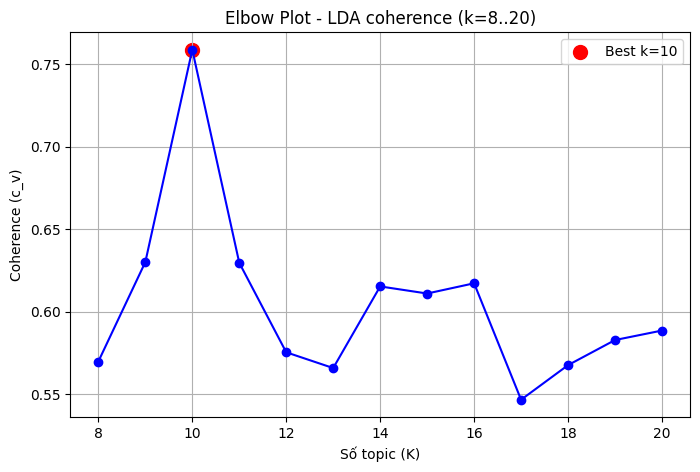

In [ ]:
# # ================== LDA sweep: k in [8..20] ==================
# import pickle, numpy as np, pandas as pd
# from sklearn.decomposition import LatentDirichletAllocation
# import gensim
# from gensim.models.coherencemodel import CoherenceModel
# import matplotlib.pyplot as plt

# # --- Load dữ liệu đã chuẩn bị ---
# DF_PATH = "/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv"
# TFIDF_PATH = "/content/drive/MyDrive/project2/project2c/tfidf_matrix.pkl"

# df = pd.read_csv(DF_PATH)
# texts = df["clean_text"].astype(str).tolist()

# with open(TFIDF_PATH, "rb") as f:
#     X_tfidf, vectorizer = pickle.load(f)

# # --- Chuẩn bị cho coherence (gensim) ---
# tokens = [t.split() for t in texts]
# dictionary = gensim.corpora.Dictionary(tokens)

# def lda_topics_top_words(model, feature_names, topn=10):
#     return [[feature_names[i] for i in comp.argsort()[:-topn-1:-1]]
#             for comp in model.components_]

# k_list = list(range(8, 21))   # chỉ từ 8 → 20
# results = []

# for k in k_list:
#     lda = LatentDirichletAllocation(
#         n_components=k,
#         random_state=42,
#         learning_method="batch",
#         max_iter=20,
#         evaluate_every=0,
#         n_jobs=-1
#     )
#     lda.fit(X_tfidf)

#     feature_names = vectorizer.get_feature_names_out()
#     topics_words = lda_topics_top_words(lda, feature_names, topn=10)

#     # coherence c_v
#     cm = CoherenceModel(topics=topics_words, texts=tokens,
#                         dictionary=dictionary, coherence="c_v")
#     coh = cm.get_coherence()

#     results.append({"k": k, "coherence_c_v": coh})
#     print(f"LDA | k={k:>2} → coherence(c_v) = {coh:.4f}")

# # --- Tổng hợp & lưu kết quả ---
# res_df = pd.DataFrame(results).sort_values("k")
# print("=== TỔNG HỢP KẾT QUẢ ===")
# print(res_df)

# SAVE_PATH = "/content/drive/MyDrive/project2/project2c/lda_k8_20_results.csv"
# res_df.to_csv(SAVE_PATH, index=False, encoding="utf-8-sig")
# print(f"ĐÃ LƯU: {SAVE_PATH}")

# # --- Vẽ elbow plot ---
# plt.figure(figsize=(8,5))
# plt.plot(res_df["k"], res_df["coherence_c_v"], marker="o", linestyle="-", color="blue")
# plt.xlabel("Số topic (K)")
# plt.ylabel("Coherence (c_v)")
# plt.title("Elbow Plot - LDA coherence (k=8..20)")
# plt.grid(True)

# # highlight điểm tốt nhất
# best_idx = res_df["coherence_c_v"].idxmax()
# best_k = res_df.loc[best_idx, "k"]
# best_val = res_df.loc[best_idx, "coherence_c_v"]
# plt.scatter(best_k, best_val, color="red", s=100, label=f"Best k={best_k}")
# plt.legend()
# plt.show()


In [ ]:

# # --- chọn k tốt nhất và train final LDA + lưu ---
# best_row = res_df.sort_values("coherence_c_v", ascending=False).iloc[0]
# best_k = int(best_row["k"])
# print(f" Best k theo coherence: {best_k}")

# final_lda = LatentDirichletAllocation(
#     n_components=best_k, random_state=42, learning_method="batch",
#     max_iter=20, evaluate_every=0, n_jobs=-1
# ).fit(X_tfidf)

# import joblib
# joblib.dump(final_lda, f"/content/drive/MyDrive/project2/project2c/lda_final_k{best_k}.joblib")
# print(f"ĐÃ LƯU MODEL: models/lda_final_k{best_k}.joblib")

# # --- In top từ của model tốt nhất (mỗi topic 15 từ) ---
# feature_names = vectorizer.get_feature_names_out()
# topn = 15
# for idx, comp in enumerate(final_lda.components_):
#     top_words = [feature_names[i] for i in comp.argsort()[:-topn-1:-1]]
#     print(f"Topic {idx:02d}: {', '.join(top_words)}")

 Best k theo coherence: 10
ĐÃ LƯU MODEL: models/lda_final_k10.joblib
Topic 00: việt_nam, có_thể, trường, ảnh, đồng, đi, học_sinh, triệu, hà_nội, phát_triển, công_ty, đường, đại_học, hàng, tổ_chức
Topic 01: tỉnh, bị_cáo, án, công_an, vụ án, điều_tra, đối_tượng, tội, đại_hội, ủy, hành_vi, quy_định, tù, nhân_dân, cơ_quan
Topic 02: cổ_phiếu, esg, giao_dịch, ngân_hàng, thị_trường, tỷ, usd, chứng_khoán, nhà_đầu_tư, vàng, doanh_nghiệp, phiên, tỷ đồng, mã, tỷ usd
Topic 03: ung_thư, bệnh_nhân, điều_trị, bác_sĩ, bệnh_viện, phẫu_thuật, người_bệnh, bệnh, bs, khối_u, triệu_chứng, tế_bào, mổ, đa_khoa, phổi
Topic 04: ukraine, trump, nga, tổng_thống, tên_lửa, uav, israel, kiev, nobel, tổng_thống trump, tomahawk, nato, gaza, hamas, moscow
Topic 05: đấu, trận, đội_tuyển, giải, cầu_thủ, thi_đấu, malaysia, trận đấu, vô_địch, vợt, vđv, giải đấu, đội, giành, fifa
Topic 06: thí_sinh, xét_tuyển, tuyển_sinh, trúng_tuyển, xét tuyển, tổ_hợp, tốt_nghiệp thpt, thi tốt_nghiệp, xét, học_bạ, nguyện_vọng, vu_mông, phư

### LDA


Tạo ma trận đếm từ (counts matrix) với CountVectorizer...
Hoàn thành. Shape của ma trận đếm: (7052, 16255)
LDA (counts) | k= 8 → coherence(c_v) = 0.5902
LDA (counts) | k= 9 → coherence(c_v) = 0.6353
LDA (counts) | k=10 → coherence(c_v) = 0.6352
LDA (counts) | k=11 → coherence(c_v) = 0.6295
LDA (counts) | k=12 → coherence(c_v) = 0.6378
LDA (counts) | k=13 → coherence(c_v) = 0.6642
LDA (counts) | k=14 → coherence(c_v) = 0.6504
LDA (counts) | k=15 → coherence(c_v) = 0.6631
LDA (counts) | k=16 → coherence(c_v) = 0.6498
LDA (counts) | k=17 → coherence(c_v) = 0.6580
LDA (counts) | k=18 → coherence(c_v) = 0.6342
LDA (counts) | k=19 → coherence(c_v) = 0.6610
LDA (counts) | k=20 → coherence(c_v) = 0.6548
=== TỔNG HỢP KẾT QUẢ ===
     k  coherence_c_v
0    8       0.590207
1    9       0.635294
2   10       0.635191
3   11       0.629545
4   12       0.637770
5   13       0.664177
6   14       0.650373
7   15       0.663052
8   16       0.649847
9   17       0.657971
10  18       0.634163
11  19

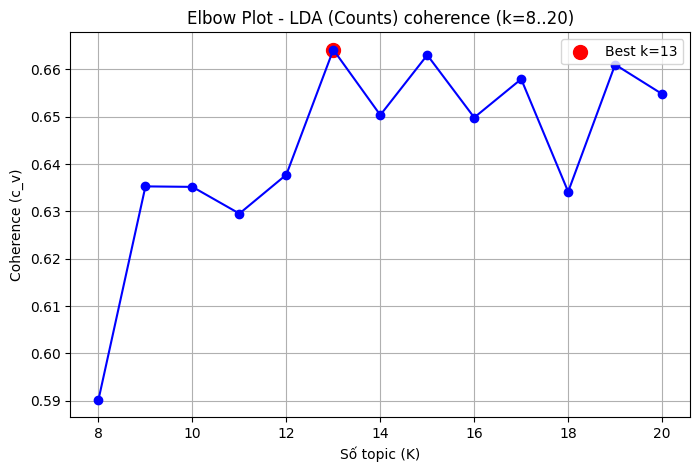

 Best k theo coherence: 13
ĐÃ LƯU MODEL: /content/drive/MyDrive/project2/project2c/lda_counts_final_k13.joblib
Topic 00: nga, ukraine, tổng_thống, mỹ, trump, có_thể, tấn_công, bay, khu_vực, lực_lượng, máy_bay, tên_lửa, quân_đội, uav, ảnh
Topic 01: việt_nam, phát_triển, doanh_nghiệp, công_nghệ, kinh_tế, có_thể, quốc_tế, không_chỉ, quốc_gia, đầu_tư, xây_dựng, bền_vững, hệ_thống, giúp, thị_trường
Topic 02: công_an, xe, hành_vi, quy_định, đường, đi, vụ, vi_phạm, xử_lý, tài_xế, giao_thông, trường_hợp, có_thể, cơ_quan, điều_tra
Topic 03: việt_nam, tỉnh, tổ_chức, chủ_tịch, phát_triển, văn_hóa, ban, xây_dựng, nhân_dân, chính_trị, công_tác, đảng, ủy, thực_hiện, đất_nước
Topic 04: giải, đấu, trận, việt_nam, đội_tuyển, thi_đấu, đội, giành, cầu_thủ, malaysia, vòng, ảnh, hai, vđv, chiến_thắng
Topic 05: xe, đồng, mẫu, triệu, giá, ảnh, có_thể, hãng, khách_hàng, thiết_kế, sử_dụng, hai, đi, việt_nam, ô_tô
Topic 06: hàng, du_khách, ảnh, quán, món, đồng, du_lịch, sản_phẩm, đi, gia_đình, hà_nội, khu, ngườ

In [ ]:
# ================== LDA sweep: k in [8..20] ==================
import pickle, numpy as np, pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
# THÊM: Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import joblib

# --- Load dữ liệu đã chuẩn bị ---
DF_PATH = "/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv"


df = pd.read_csv(DF_PATH)
texts = df["clean_text"].astype(str).tolist()

# === THAY ĐỔI QUAN TRỌNG: SỬ DỤNG CountVectorizer THAY VÌ TF-IDF ===

# LDA hoạt động trên ma trận đếm (counts), không phải ma trận trọng số (tfidf).
print("Tạo ma trận đếm từ (counts matrix) với CountVectorizer...")
counts_vectorizer = CountVectorizer(
    max_df=0.9,     # Lọc bỏ từ xuất hiện trong > 90% tài liệu
    min_df=5,       # Lọc bỏ từ xuất hiện trong < 5 tài liệu
    # stop_words=[...]
)
X_counts = counts_vectorizer.fit_transform(texts)
print(f"Hoàn thành. Shape của ma trận đếm: {X_counts.shape}")
# ===================================================================

# --- Chuẩn bị cho coherence (gensim) ---
tokens = [t.split() for t in texts]
dictionary = gensim.corpora.Dictionary(tokens)

# Đổi tên hàm cho chung chung hơn
def get_model_top_words(model, feature_names, topn=10):
    return [[feature_names[i] for i in comp.argsort()[:-topn-1:-1]]
            for comp in model.components_]

k_list = list(range(8, 21))  # chỉ từ 8 → 20
results = []

for k in k_list:
    lda = LatentDirichletAllocation(
        n_components=k,
        random_state=42,
        learning_method="batch",
        max_iter=20,
        evaluate_every=0,
        n_jobs=-1
    )
    # Huấn luyện trên ma trận đếm (X_counts)
    lda.fit(X_counts)

    # Lấy feature_names từ vectorizer mới
    feature_names = counts_vectorizer.get_feature_names_out()
    topics_words = get_model_top_words(lda, feature_names, topn=10)

    # coherence c_v
    cm = CoherenceModel(topics=topics_words, texts=tokens,
                        dictionary=dictionary, coherence="c_v")
    coh = cm.get_coherence()

    results.append({"k": k, "coherence_c_v": coh})
    print(f"LDA (counts) | k={k:>2} → coherence(c_v) = {coh:.4f}")

# --- Tổng hợp & lưu kết quả ---
res_df = pd.DataFrame(results).sort_values("k")
print("=== TỔNG HỢP KẾT QUẢ ===")
print(res_df)

# Tên file kết quả để phân biệt
SAVE_PATH = "/content/drive/MyDrive/project2/project2c/lda_counts_k8_20_results.csv"
res_df.to_csv(SAVE_PATH, index=False, encoding="utf-8-sig")
print(f"ĐÃ LƯU: {SAVE_PATH}")

# --- Vẽ elbow plot ---
plt.figure(figsize=(8,5))
plt.plot(res_df["k"], res_df["coherence_c_v"], marker="o", linestyle="-", color="blue")
plt.xlabel("Số topic (K)")
plt.ylabel("Coherence (c_v)")
plt.title("Elbow Plot - LDA (Counts) coherence (k=8..20)")
plt.grid(True)

# highlight điểm tốt nhất
best_idx = res_df["coherence_c_v"].idxmax()
best_k = res_df.loc[best_idx, "k"]
best_val = res_df.loc[best_idx, "coherence_c_v"]
plt.scatter(best_k, best_val, color="red", s=100, label=f"Best k={best_k}")
plt.legend()
plt.show()

# --- chọn k tốt nhất và train final LDA + lưu ---
best_row = res_df.sort_values("coherence_c_v", ascending=False).iloc[0]
best_k = int(best_row["k"])
print(f" Best k theo coherence: {best_k}")

final_lda = LatentDirichletAllocation(
    n_components=best_k, random_state=42, learning_method="batch",
    max_iter=20, evaluate_every=0, n_jobs=-1
).fit(X_counts) #Huấn luyện trên X_counts

# Tên file model để phân biệt
FINAL_MODEL_PATH = f"/content/drive/MyDrive/project2/project2c/lda_counts_final_k{best_k}.joblib"
joblib.dump(final_lda, FINAL_MODEL_PATH)
print(f"ĐÃ LƯU MODEL: {FINAL_MODEL_PATH}")

# --- In top từ của model tốt nhất (mỗi topic 15 từ) ---
feature_names = counts_vectorizer.get_feature_names_out()
topn = 15
final_topics_words = get_model_top_words(final_lda, feature_names, topn=topn)
for idx, words in enumerate(final_topics_words):
    print(f"Topic {idx:02d}: {', '.join(words)}")


Đang tạo biểu đồ phân bổ topic cho LDA...


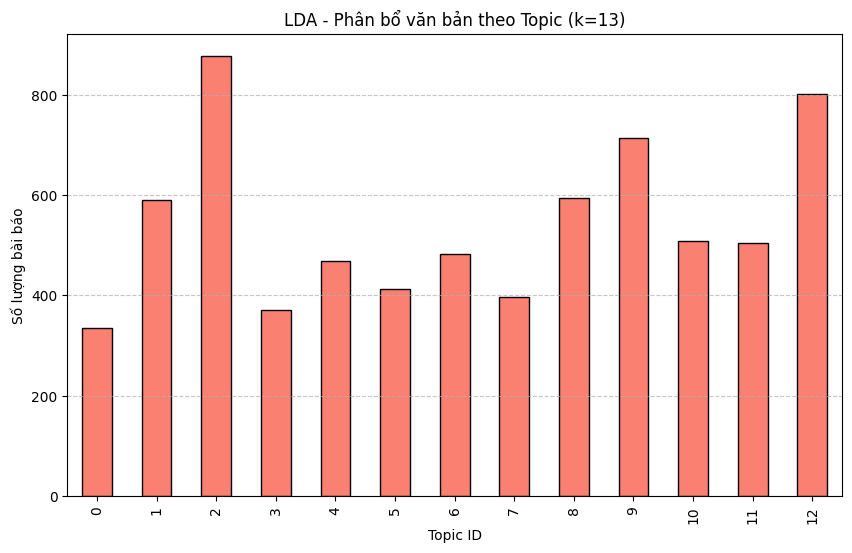

In [ ]:
# --- Vẽ biểu đồ phân bổ văn bản theo Topic (cho LDA) ---
print("\nĐang tạo biểu đồ phân bổ topic cho LDA...")

# 1. Lấy phân bổ chủ đề cho từng tài liệu
# (Sử dụng model final_lda và ma trận X_counts)
doc_topic_dist_lda = final_lda.transform(X_counts)

# 2. Tìm chủ đề chính (dominant topic) cho mỗi tài liệu
dominant_topics_lda = np.argmax(doc_topic_dist_lda, axis=1)

# 3. Đếm số lượng tài liệu cho mỗi chủ đề
topic_counts_lda = pd.Series(dominant_topics_lda).value_counts().sort_index()

# 4. Vẽ biểu đồ
plt.figure(figsize=(10, 6))
topic_counts_lda.plot(kind='bar', color='salmon', edgecolor='black')
plt.title(f'LDA - Phân bổ văn bản theo Topic (k={best_k})')
plt.xlabel('Topic ID')
plt.ylabel('Số lượng bài báo')
plt.xticks(rotation=90) # Xoay nhãn trục x để dễ đọc
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### NMF

NMF | k= 8 → coherence=0.7813 | reconstruction_error=81.09
NMF | k= 9 → coherence=0.8074 | reconstruction_error=80.88
NMF | k=10 → coherence=0.8256 | reconstruction_error=80.71
NMF | k=11 → coherence=0.8344 | reconstruction_error=80.54
NMF | k=12 → coherence=0.8348 | reconstruction_error=80.37
NMF | k=13 → coherence=0.8405 | reconstruction_error=80.24
NMF | k=14 → coherence=0.8280 | reconstruction_error=80.10
NMF | k=15 → coherence=0.8307 | reconstruction_error=79.96
NMF | k=16 → coherence=0.8273 | reconstruction_error=79.87
NMF | k=17 → coherence=0.8291 | reconstruction_error=79.73
NMF | k=18 → coherence=0.8337 | reconstruction_error=79.61
NMF | k=19 → coherence=0.8393 | reconstruction_error=79.50
NMF | k=20 → coherence=0.8367 | reconstruction_error=79.35

=== TỔNG HỢP KẾT QUẢ ===
     k  coherence_c_v  reconstruction_error
0    8       0.781346             81.094756
1    9       0.807403             80.884179
2   10       0.825600             80.710653
3   11       0.834374          

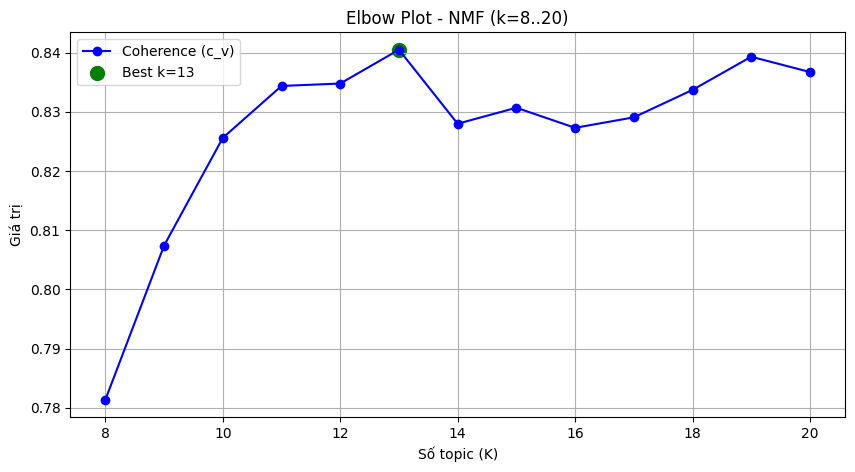

In [ ]:
# ============================================================
# KIỂM THỬ NMF VỚI NHIỀU SỐ CHỦ ĐỀ
# ============================================================
import pickle
import pandas as pd
import gensim
from gensim.models.coherencemodel import CoherenceModel
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

# --- Load dữ liệu đã chuẩn bị ---
DF_PATH = "/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv"
TFIDF_PATH = "/content/drive/MyDrive/project2/project2c/tfidf_matrix.pkl"

df = pd.read_csv(DF_PATH)
texts = df["clean_text"].astype(str).tolist()

with open(TFIDF_PATH, "rb") as f:
    X_tfidf, vectorizer = pickle.load(f)

# --- Chuẩn bị cho coherence ---
tokens = [t.split() for t in texts]
dictionary = gensim.corpora.Dictionary(tokens)

def nmf_top_words(model, feature_names, n_top_words=10):
    """Trả về top words cho từng topic"""
    topics = []
    for topic in model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
        topics.append(top_words)
    return topics

# --- Chạy thử với nhiều số chủ đề ---
k_list = list(range(8, 21))   # chỉ từ 8 → 20
results = []

for k in k_list:
    nmf = NMF(
        n_components=k,
        random_state=42,
        max_iter=500,
        init="nndsvda",
        solver="cd"
    )
    nmf.fit(X_tfidf)

    feature_names = vectorizer.get_feature_names_out()
    topics_words = nmf_top_words(nmf, feature_names, n_top_words=10)

    # coherence score
    cm = CoherenceModel(topics=topics_words, texts=tokens, dictionary=dictionary, coherence="c_v")
    coherence = cm.get_coherence()

    # reconstruction error
    rec_error = nmf.reconstruction_err_

    results.append({"k": k, "coherence_c_v": coherence, "reconstruction_error": rec_error})
    print(f"NMF | k={k:>2} → coherence={coherence:.4f} | reconstruction_error={rec_error:.2f}")

# --- Tổng hợp kết quả ---
res_df = pd.DataFrame(results).sort_values("k")
print("\n=== TỔNG HỢP KẾT QUẢ ===")
print(res_df)

SAVE_PATH = "/content/drive/MyDrive/project2/project2c/nmf_k8_20_results.csv"
res_df.to_csv(SAVE_PATH, index=False, encoding="utf-8-sig")
print(f"ĐÃ LƯU: {SAVE_PATH}")

# --- Vẽ elbow plot ---
plt.figure(figsize=(10,5))
plt.plot(res_df["k"], res_df["coherence_c_v"], marker="o", label="Coherence (c_v)", color="blue")
plt.xlabel("Số topic (K)")
plt.ylabel("Giá trị")
plt.title("Elbow Plot - NMF (k=8..20)")
plt.legend()
plt.grid(True)

# highlight điểm tốt nhất theo coherence
best_idx = res_df["coherence_c_v"].idxmax()
best_k = res_df.loc[best_idx, "k"]
best_val = res_df.loc[best_idx, "coherence_c_v"]
plt.scatter(best_k, best_val, color="green", s=100, label=f"Best k={best_k}")
plt.legend()
plt.show()


In [ ]:
from sklearn.decomposition import NMF
import joblib

# --- Đặt k cố định ---
best_k = 13
print(f" Sử dụng K = {best_k} cho NMF cuối cùng")

# Huấn luyện mô hình NMF cuối cùng
final_nmf = NMF(
    n_components=best_k,
    random_state=42,
    max_iter=500,
    init="nndsvda",
    solver="cd"
).fit(X_tfidf)

# Lưu model
save_path = f"/content/drive/MyDrive/project2/project2c/nmf_final_k{best_k}.joblib"
joblib.dump(final_nmf, save_path)
print(f"ĐÃ LƯU MODEL: {save_path}")

# --- In top từ cho từng topic ---
feature_names = vectorizer.get_feature_names_out()
topn = 15
for idx, comp in enumerate(final_nmf.components_):
    top_words = [feature_names[i] for i in comp.argsort()[:-topn-1:-1]]
    print(f"Topic {idx:02d}: {', '.join(top_words)}")

 Sử dụng K = 13 cho NMF cuối cùng
ĐÃ LƯU MODEL: /content/drive/MyDrive/project2/project2c/nmf_final_k13.joblib
Topic 00: doanh_nghiệp, việt_nam, lao_động, phát_triển, esg, công_nghệ, bền_vững, kinh_tế, thị_trường, công_ty, quốc_tế, quốc_gia, phát_triển bền_vững, tài_chính, sản_phẩm
Topic 01: chồng, vợ, mẹ, gái, đi, câu_chuyện, hôn_nhân, trai, dantri, bố_mẹ, yêu, hai, đàn_ông, chẳng, sống
Topic 02: xe, mẫu, mẫu xe, ô_tô, sạc, tài_xế, hãng, toyota, xe_điện, doanh_số, vinfast, vf, phiên_bản, triệu đồng, sản_phẩm
Topic 03: đấu, trận, giải, vợt, vô_địch, trận đấu, thi_đấu, giành, giải đấu, chiến_thắng, vđv, đội_tuyển, đội, alcaraz, djokovic
Topic 04: trường, học_sinh, đại_học, học, thi, giáo_dục, nhà_trường, trường đại_học, giáo_viên, sinh_viên, thí_sinh, thpt, lớp, học_tập, phụ_huynh
Topic 05: công_an, hành_vi, điều_tra, vụ, tài_xế, vi_phạm, quy_định, đối_tượng, cơ_quan, án, cảnh_sát, tỉnh, hình_sự, luật_sư, xã
Topic 06: ukraine, nga, tên_lửa, tổng_thống, uav, trump, tấn_công, kiev, moscow

In [ ]:
from sklearn.decomposition import NMF
import joblib

# --- Đặt k cố định ---
best_k = 10
print(f" Sử dụng K = {best_k} cho NMF cuối cùng")

# Huấn luyện mô hình NMF cuối cùng
final_nmf = NMF(
    n_components=best_k,
    random_state=42,
    max_iter=500,
    init="nndsvda",
    solver="cd"
).fit(X_tfidf)

# Lưu model
save_path = f"/content/drive/MyDrive/project2/project2c/nmf_final_k{best_k}.joblib"
joblib.dump(final_nmf, save_path)
print(f"ĐÃ LƯU MODEL: {save_path}")

# --- In top từ cho từng topic ---
feature_names = vectorizer.get_feature_names_out()
topn = 15
for idx, comp in enumerate(final_nmf.components_):
    top_words = [feature_names[i] for i in comp.argsort()[:-topn-1:-1]]
    print(f"Topic {idx:02d}: {', '.join(top_words)}")



 Sử dụng K = 10 cho NMF cuối cùng
ĐÃ LƯU MODEL: /content/drive/MyDrive/project2/project2c/nmf_final_k10.joblib
Topic 00: doanh_nghiệp, việt_nam, phát_triển, lao_động, công_ty, kinh_tế, tỷ, đồng, thị_trường, công_nghệ, đầu_tư, esg, xây_dựng, bền_vững, tỷ đồng
Topic 01: chồng, vợ, mẹ, gái, đi, câu_chuyện, hôn_nhân, dantri, trai, bố_mẹ, yêu, hai, đàn_ông, chẳng, tiền
Topic 02: xe, mẫu, mẫu xe, ô_tô, tài_xế, triệu, triệu đồng, đồng, giá, sạc, hãng, toyota, xe_điện, doanh_số, đường
Topic 03: đấu, trận, giải, vợt, vô_địch, trận đấu, thi_đấu, giành, giải đấu, chiến_thắng, vđv, đội_tuyển, đội, alcaraz, djokovic
Topic 04: trường, học_sinh, đại_học, học, thi, giáo_dục, nhà_trường, trường đại_học, sinh_viên, giáo_viên, thí_sinh, thpt, lớp, học_tập, phụ_huynh
Topic 05: malaysia, cầu_thủ, fifa, fam, đội_tuyển, nhập_tịch, bóng_đá, đội_tuyển malaysia, cầu_thủ nhập_tịch, phạt, afc, đội_tuyển việt_nam, kháng_cáo, trận, bóng_đá malaysia
Topic 06: ukraine, nga, tên_lửa, tổng_thống, uav, trump, tấn_công, 

### gan nhan


Đang tạo lại CountVectorizer và ma trận X_counts...
Hoàn thành. Shape ma trận: (7052, 16255)
LDA - Topic 00: nga, ukraine, tổng_thống, mỹ, trump, có_thể, tấn_công, bay, khu_vực, lực_lượng, máy_bay, tên_lửa, quân_đội, uav, ảnh
LDA - Topic 01: việt_nam, phát_triển, doanh_nghiệp, công_nghệ, kinh_tế, có_thể, quốc_tế, không_chỉ, quốc_gia, đầu_tư, xây_dựng, bền_vững, hệ_thống, giúp, thị_trường
LDA - Topic 02: công_an, xe, hành_vi, quy_định, đường, đi, vụ, vi_phạm, xử_lý, tài_xế, giao_thông, trường_hợp, có_thể, cơ_quan, điều_tra
LDA - Topic 03: việt_nam, tỉnh, tổ_chức, chủ_tịch, phát_triển, văn_hóa, ban, xây_dựng, nhân_dân, chính_trị, công_tác, đảng, ủy, thực_hiện, đất_nước
LDA - Topic 04: giải, đấu, trận, việt_nam, đội_tuyển, thi_đấu, đội, giành, cầu_thủ, malaysia, vòng, ảnh, hai, vđv, chiến_thắng
LDA - Topic 05: xe, đồng, mẫu, triệu, giá, ảnh, có_thể, hãng, khách_hàng, thiết_kế, sử_dụng, hai, đi, việt_nam, ô_tô
LDA - Topic 06: hàng, du_khách, ảnh, quán, món, đồng, du_lịch, sản_phẩm, đi, gia

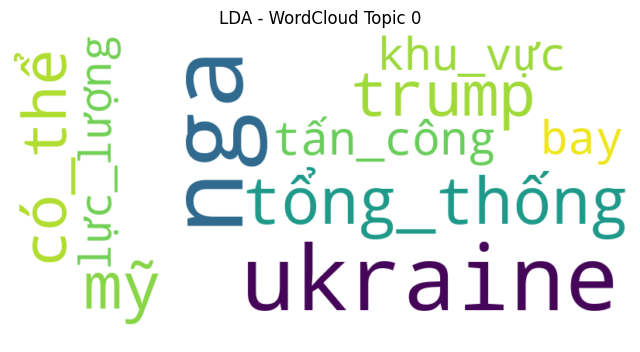

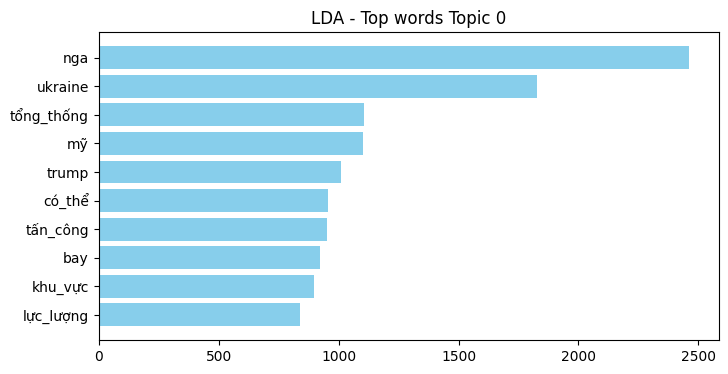

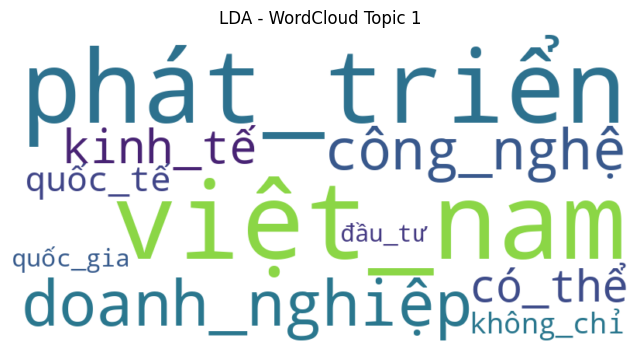

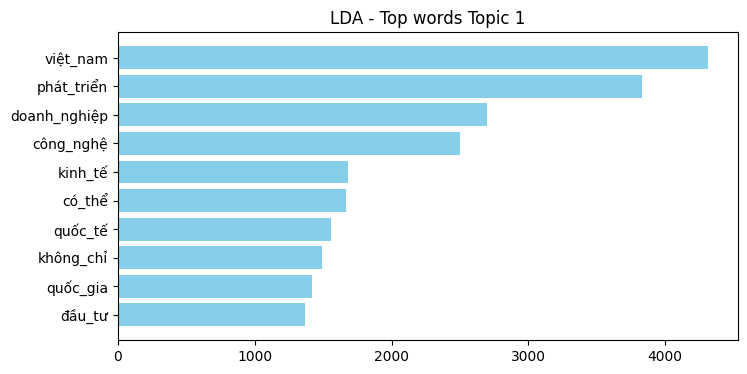

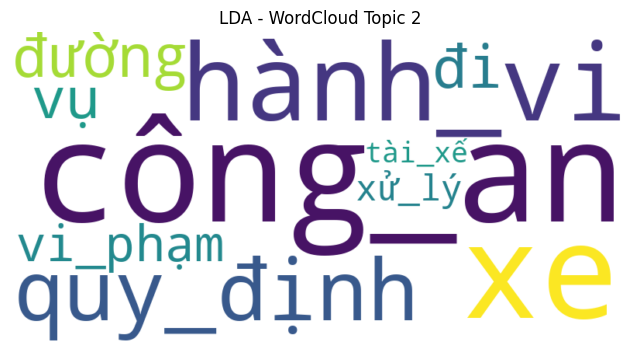

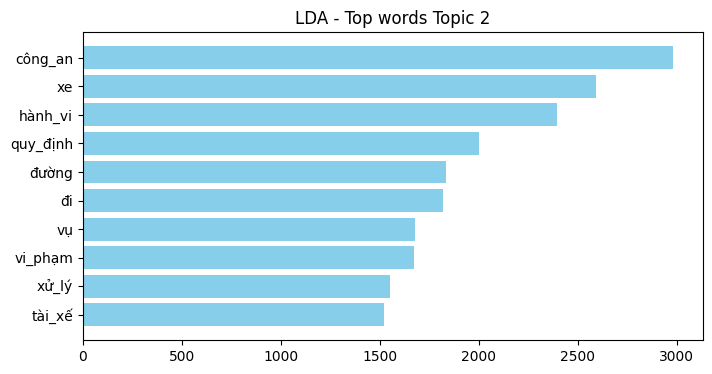

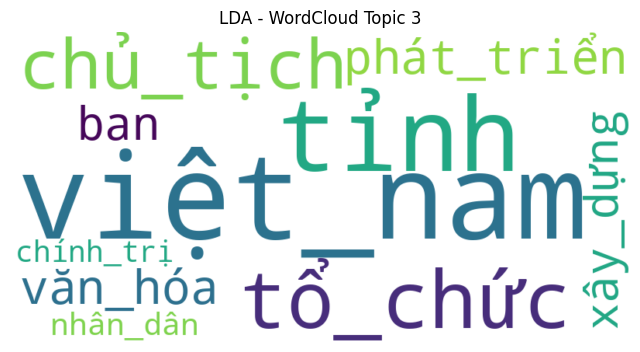

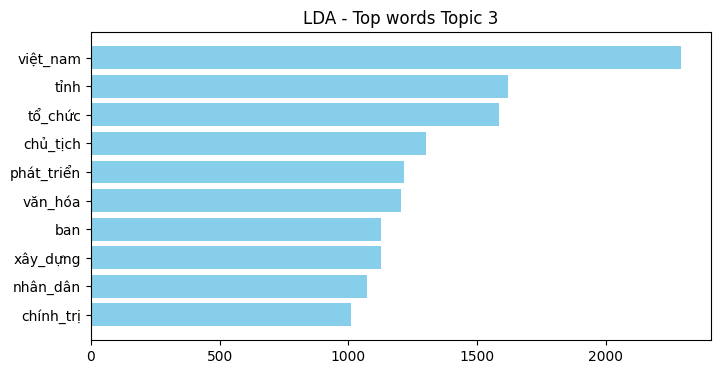

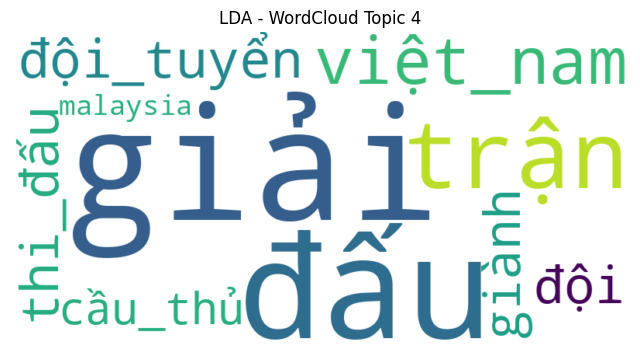

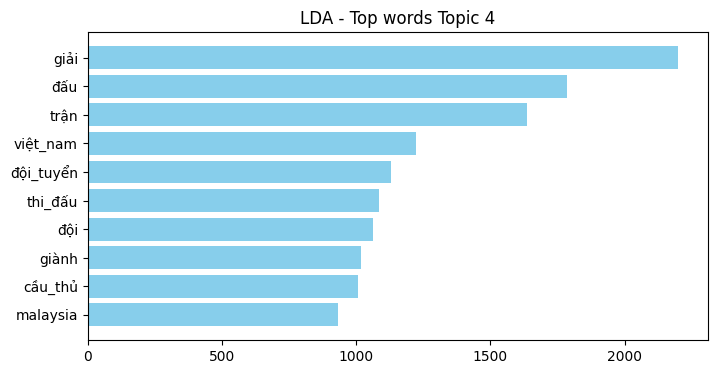

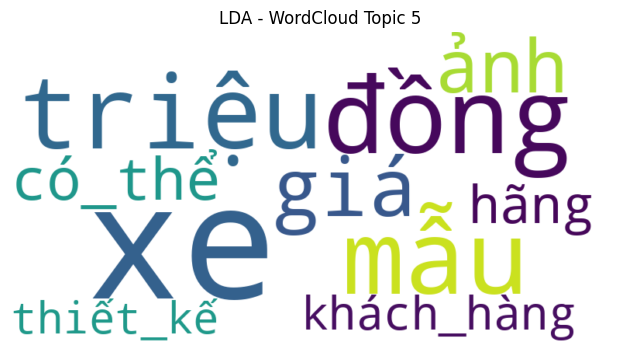

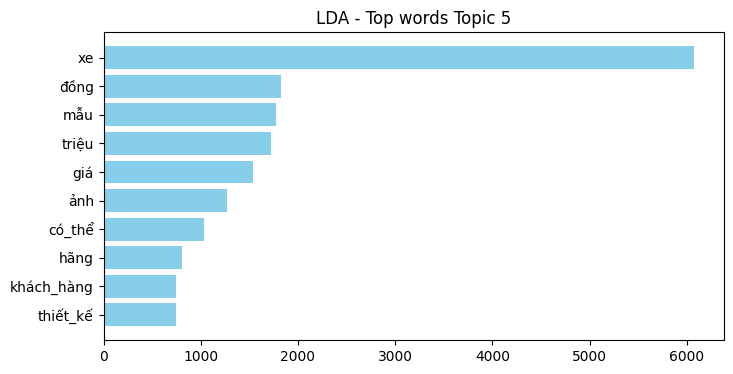

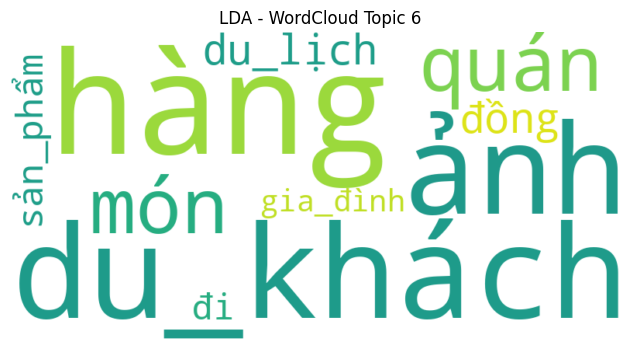

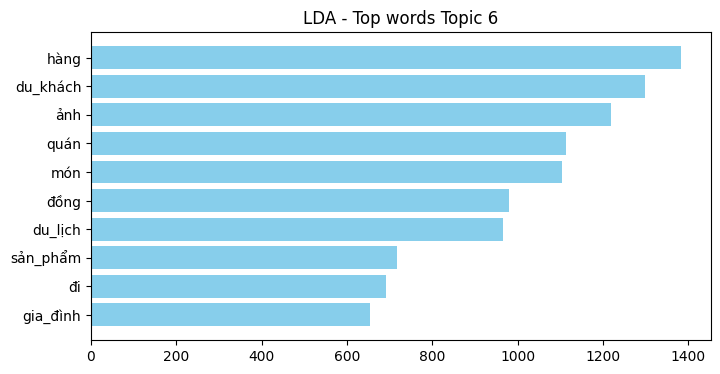

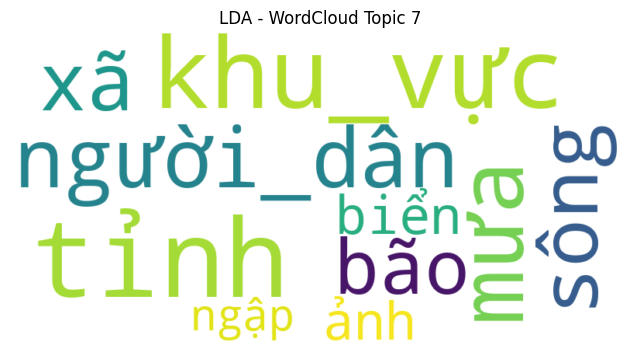

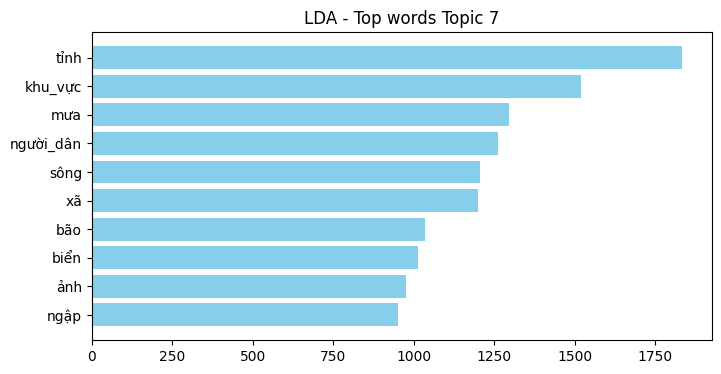

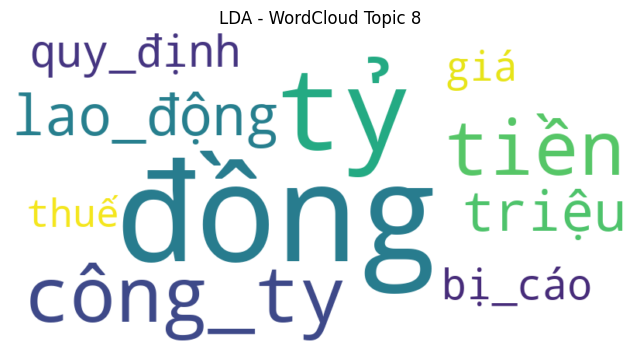

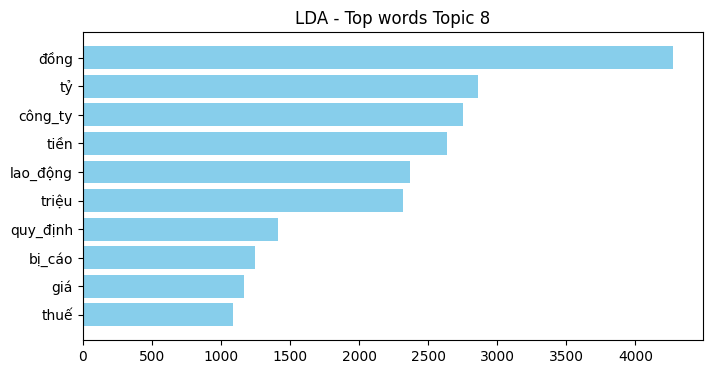

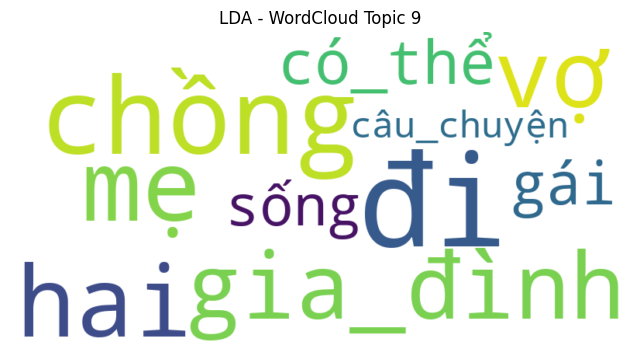

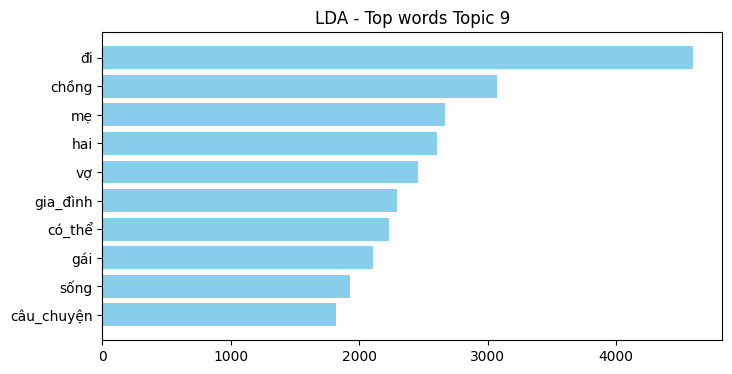

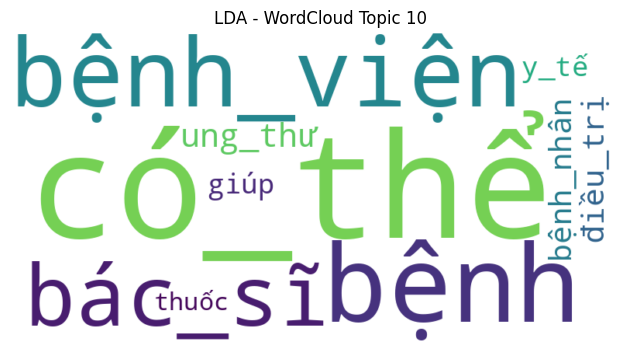

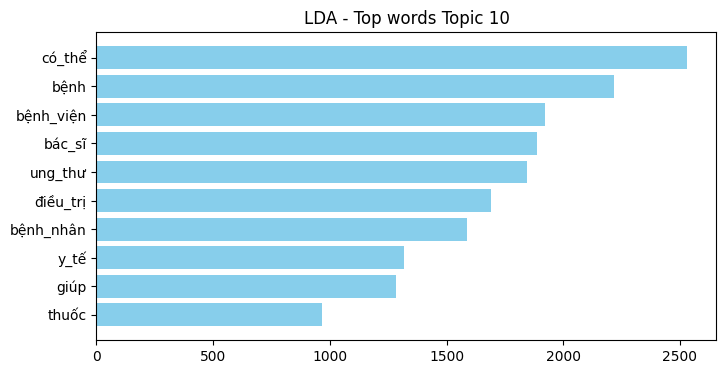

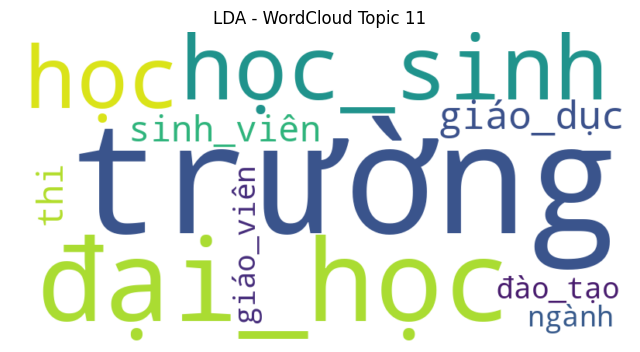

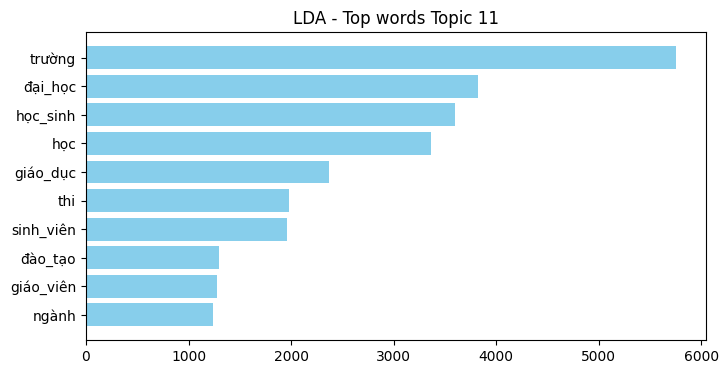

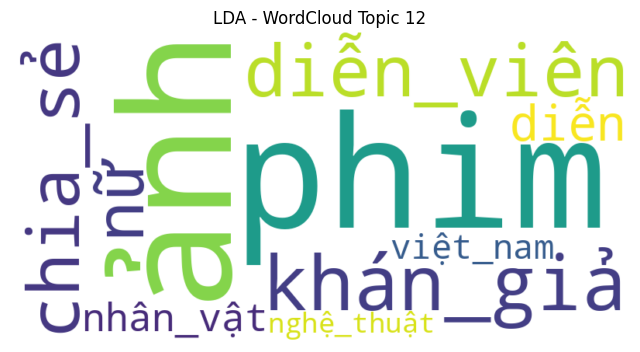

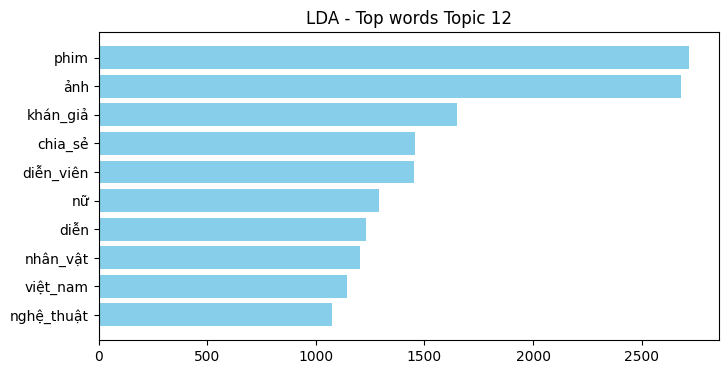

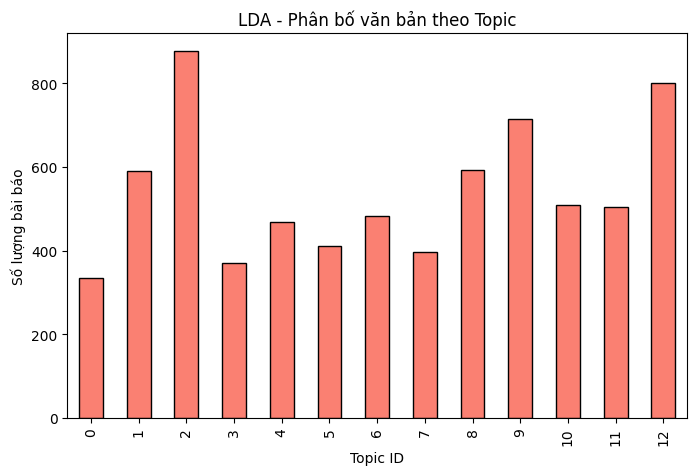

In [ ]:
# ============================================================
# PHÂN TÍCH TOPIC VỚI LDA
# ============================================================
import pickle, pandas as pd, joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# --- Load dữ liệu & Model ---
DF_PATH = "/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv"

MODEL_PATH = "/content/drive/MyDrive/project2/project2c/lda_counts_final_k13.joblib"

df = pd.read_csv(DF_PATH)
texts = df["clean_text"].astype(str).tolist()

# === TẠO LẠI COUNTVECTORIZER ===
# Model được huấn luyện trên ma trận đếm (counts).
# tạo lại chính xác vectorizer và ma trận đó.
print("Đang tạo lại CountVectorizer và ma trận X_counts...")
counts_vectorizer = CountVectorizer(
    max_df=0.9,     # Giữ cài đặt này giống hệt script huấn luyện
    min_df=5,       # Giữ cài đặt này giống hệt script huấn luyện
    # stop_words=[...]
)
X_counts = counts_vectorizer.fit_transform(texts)
print(f"Hoàn thành. Shape ma trận: {X_counts.shape}")
# ====================================================


lda = joblib.load(MODEL_PATH)
# Lấy feature_names từ counts_vectorizer
feature_names = counts_vectorizer.get_feature_names_out()

# --- Top words mỗi topic ---
topn = 15
topic_words = []
for idx, comp in enumerate(lda.components_):
    top_idx = comp.argsort()[:-topn-1:-1]
    words = [feature_names[i] for i in top_idx]
    topic_words.append(", ".join(words))
    print(f"LDA - Topic {idx:02d}: {', '.join(words)}")

# --- Gán topic cho văn bản ---
# Chạy transform trên X_counts
doc_topic = lda.transform(X_counts)
df["topic_id"] = doc_topic.argmax(axis=1)
df["topic_words"] = df["topic_id"].apply(lambda x: topic_words[x])

SAVE_PATH = "/content/drive/MyDrive/project2/project2c/lda_topic_assignment.csv"
df.to_csv(SAVE_PATH, index=False, encoding="utf-8-sig")
print(f"ĐÃ LƯU: {SAVE_PATH}")

# --- Trực quan hóa  ---
for idx, comp in enumerate(lda.components_):
    # Lấy 10 từ hàng đầu cho wordcloud/barplot
    top_idx_viz = comp.argsort()[:-11:-1]
    words = [feature_names[i] for i in top_idx_viz]
    weights = comp[top_idx_viz] # Lấy trọng số (count-based) từ components

    # WordCloud
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(zip(words, weights)))
    plt.figure(figsize=(8,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"LDA - WordCloud Topic {idx}")
    plt.show()

    # Barplot
    plt.figure(figsize=(8,4))
    plt.barh(words[::-1], weights[::-1], color="skyblue")
    plt.title(f"LDA - Top words Topic {idx}")
    plt.show()

# --- Phân bố số văn bản theo topic ---
topic_counts = df["topic_id"].value_counts().sort_index()
plt.figure(figsize=(8,5))
topic_counts.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("LDA - Phân bố văn bản theo Topic")
plt.xlabel("Topic ID")
plt.ylabel("Số lượng bài báo")
plt.show()

NMF - Topic 00: doanh_nghiệp, việt_nam, lao_động, phát_triển, esg, công_nghệ, bền_vững, kinh_tế, thị_trường, công_ty, quốc_tế, quốc_gia, phát_triển bền_vững, tài_chính, sản_phẩm
NMF - Topic 01: chồng, vợ, mẹ, gái, đi, câu_chuyện, hôn_nhân, trai, dantri, bố_mẹ, yêu, hai, đàn_ông, chẳng, sống
NMF - Topic 02: xe, mẫu, mẫu xe, ô_tô, sạc, tài_xế, hãng, toyota, xe_điện, doanh_số, vinfast, vf, phiên_bản, triệu đồng, sản_phẩm
NMF - Topic 03: đấu, trận, giải, vợt, vô_địch, trận đấu, thi_đấu, giành, giải đấu, chiến_thắng, vđv, đội_tuyển, đội, alcaraz, djokovic
NMF - Topic 04: trường, học_sinh, đại_học, học, thi, giáo_dục, nhà_trường, trường đại_học, giáo_viên, sinh_viên, thí_sinh, thpt, lớp, học_tập, phụ_huynh
NMF - Topic 05: công_an, hành_vi, điều_tra, vụ, tài_xế, vi_phạm, quy_định, đối_tượng, cơ_quan, án, cảnh_sát, tỉnh, hình_sự, luật_sư, xã
NMF - Topic 06: ukraine, nga, tên_lửa, tổng_thống, uav, trump, tấn_công, kiev, moscow, pokrovsk, lực_lượng, mỹ, quân_đội, tomahawk, rfaf
NMF - Topic 07: u

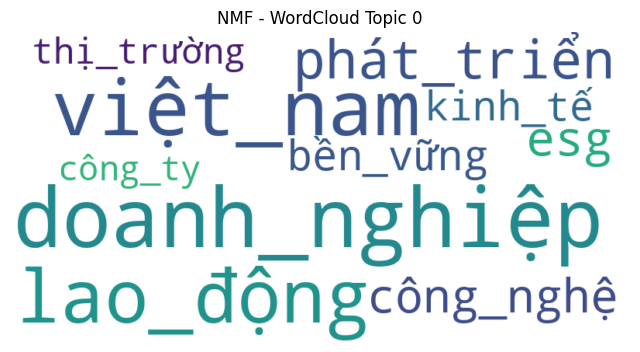

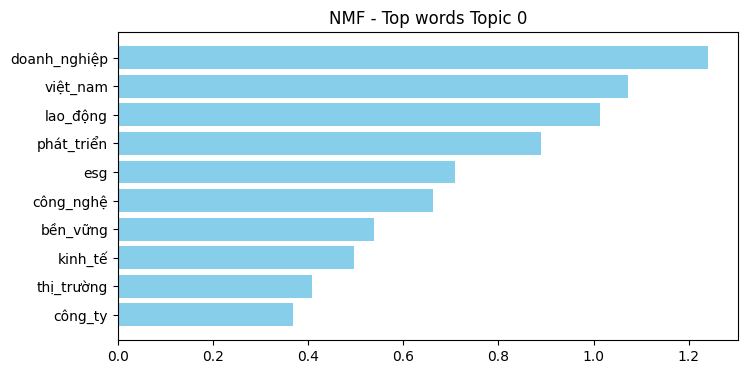

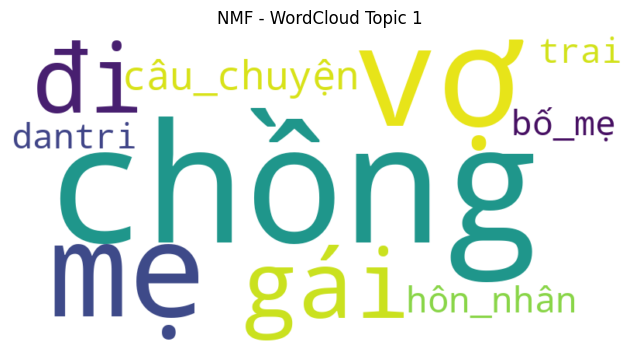

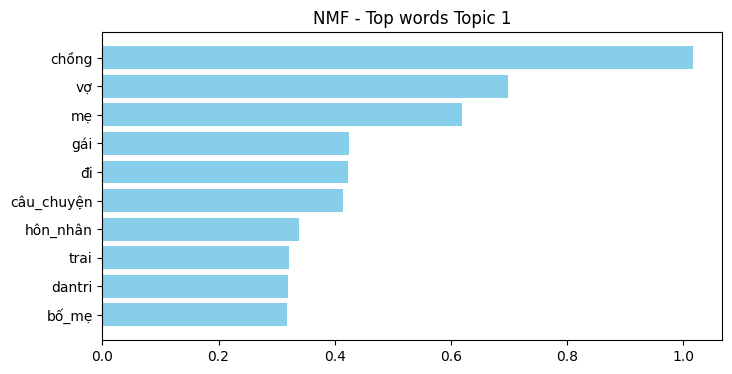

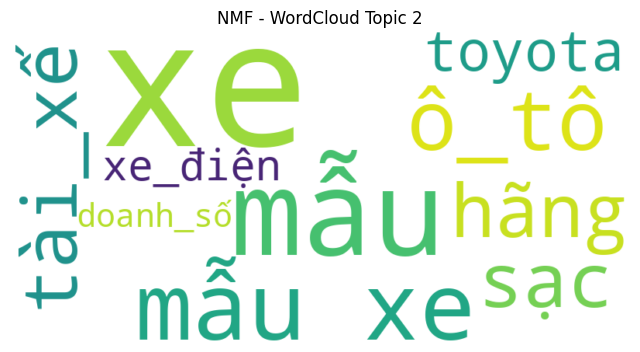

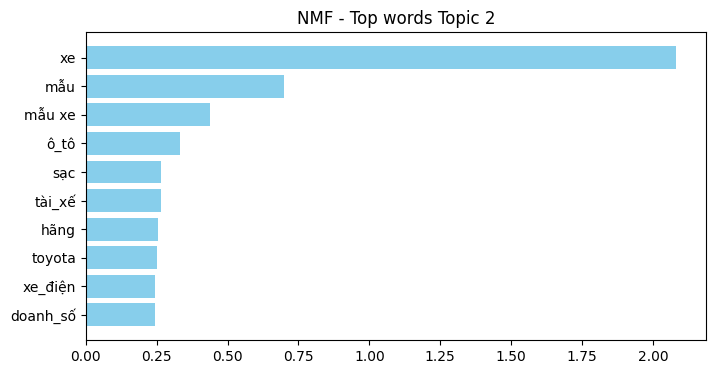

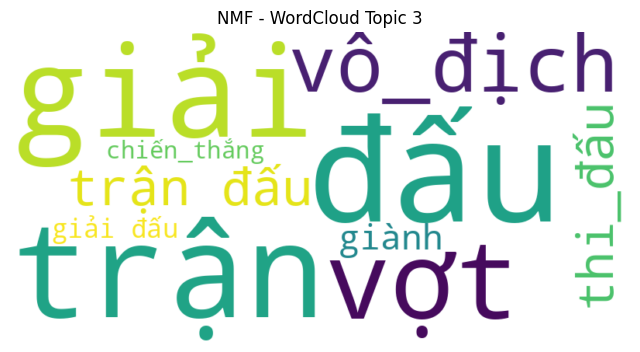

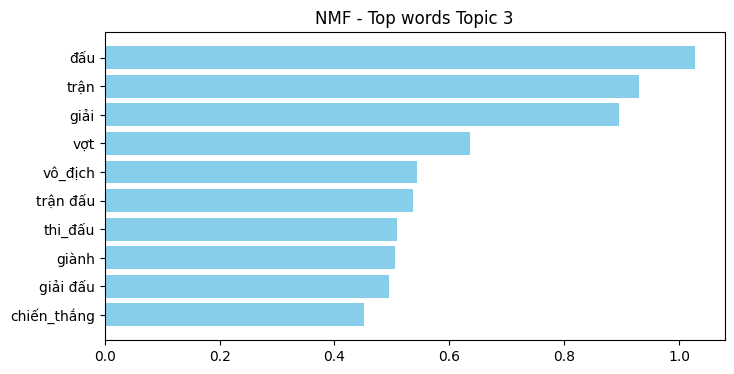

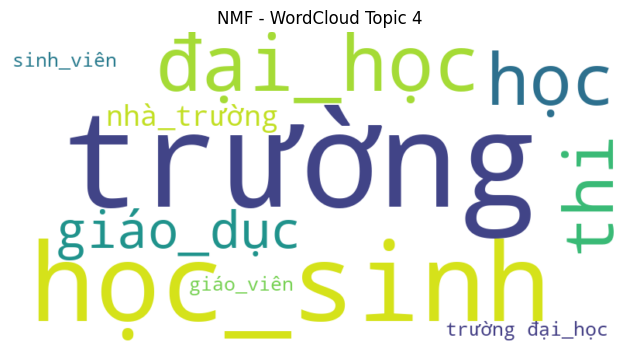

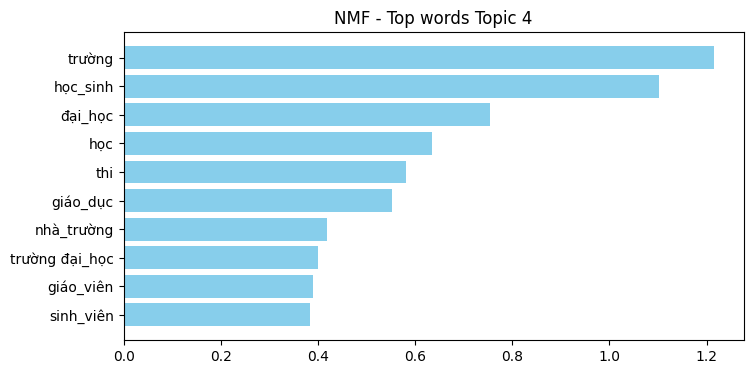

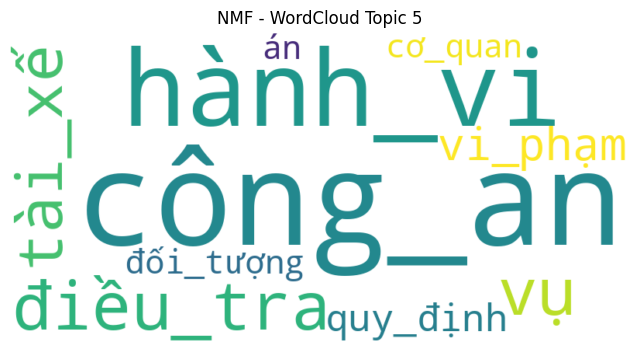

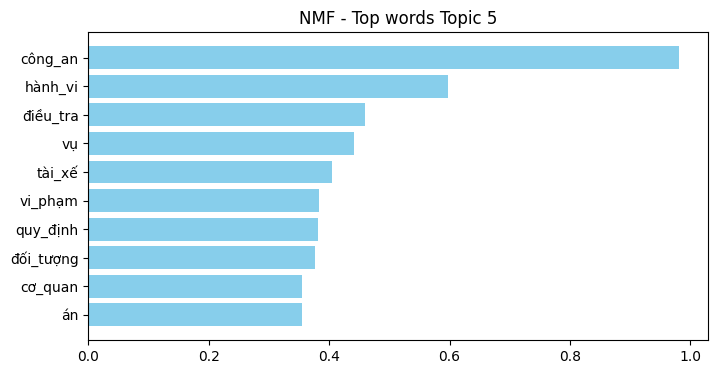

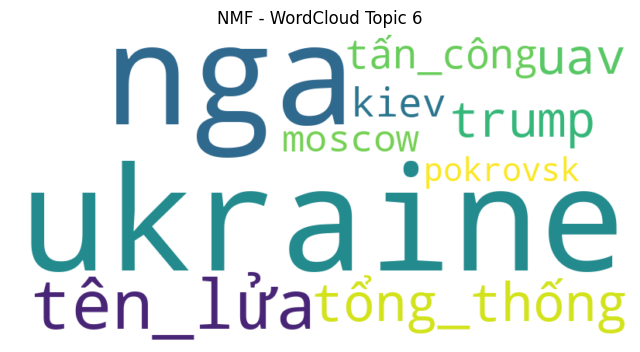

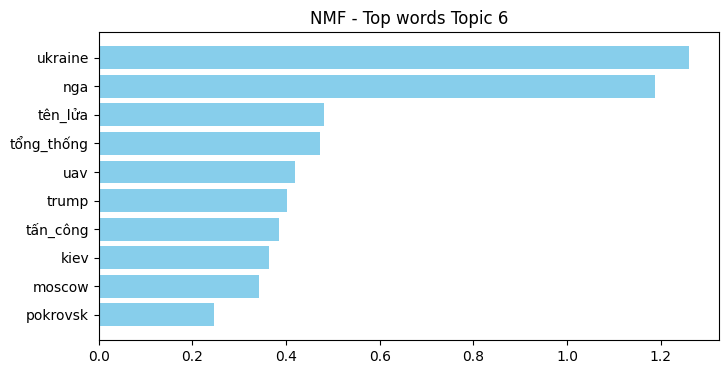

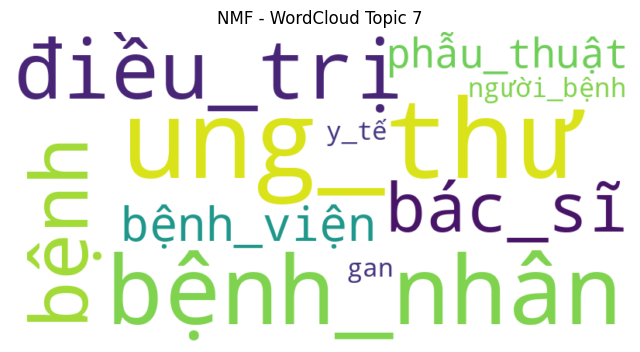

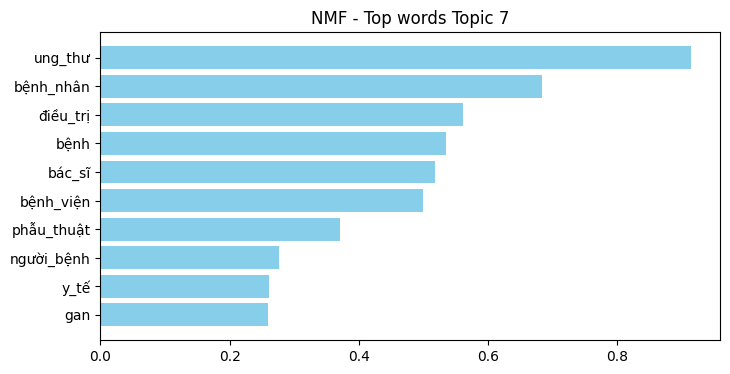

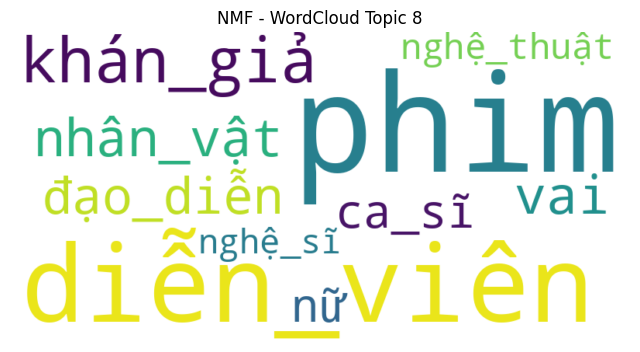

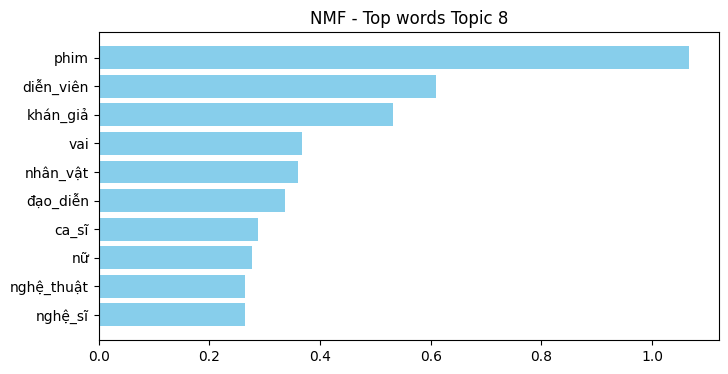

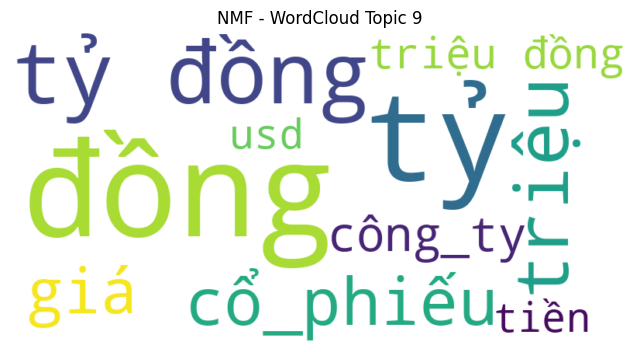

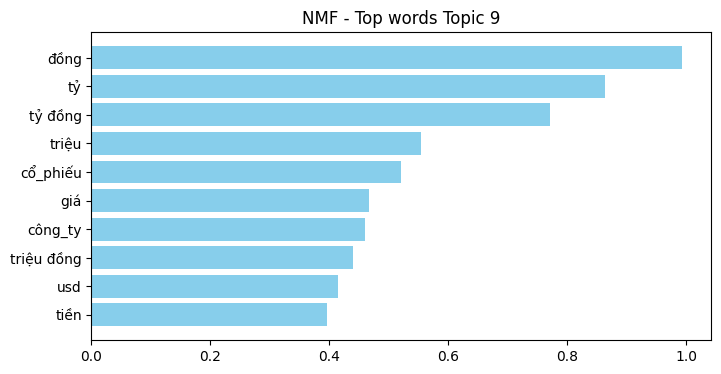

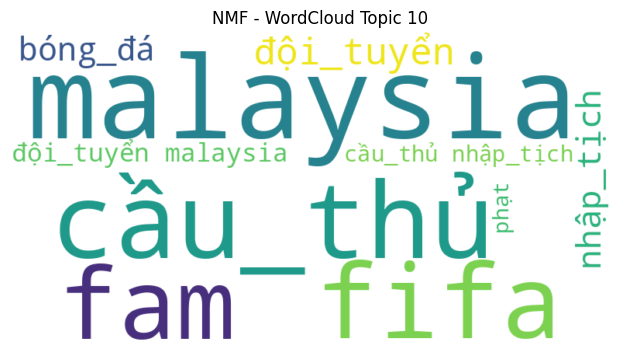

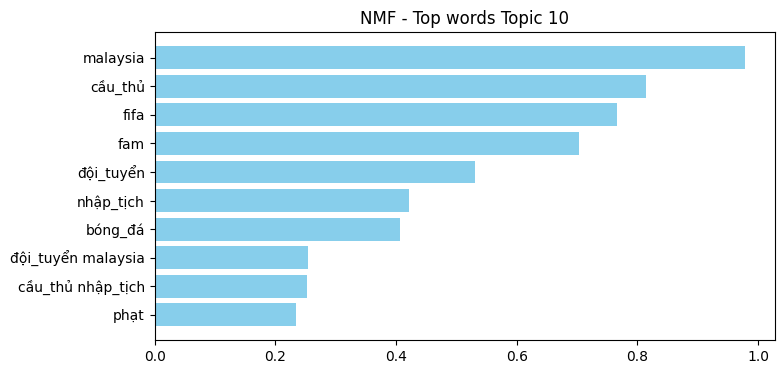

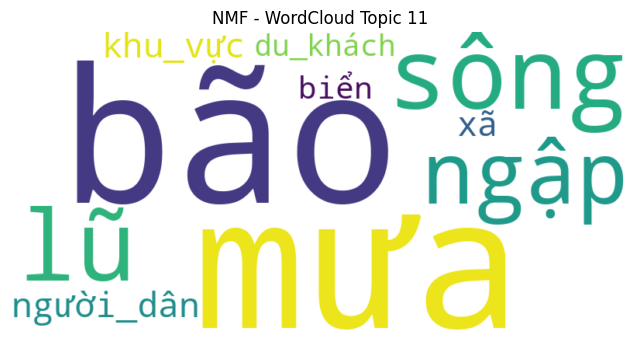

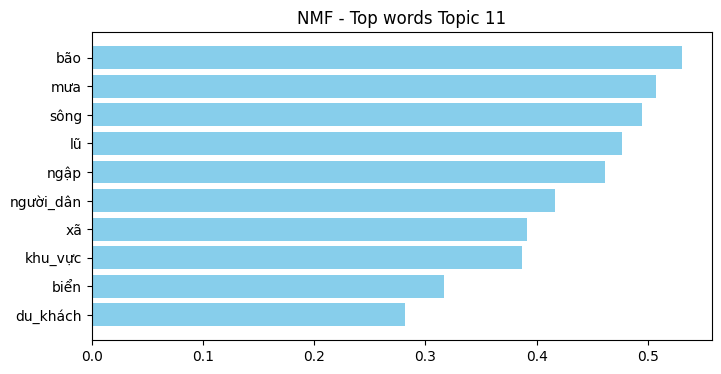

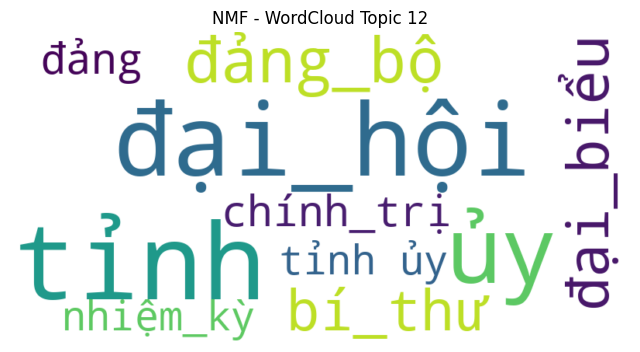

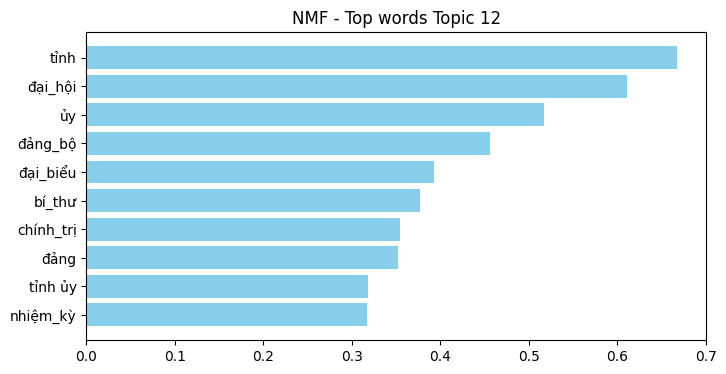

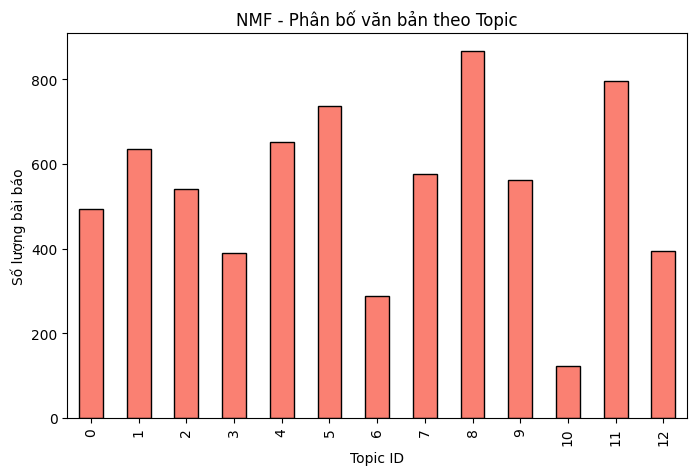

In [ ]:
# ============================================================
# PHÂN TÍCH TOPIC VỚI NMF
# ============================================================
import pickle, pandas as pd, joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --- Load dữ liệu & TF-IDF ---
DF_PATH = "/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv"
TFIDF_PATH = "/content/drive/MyDrive/project2/project2c/tfidf_matrix.pkl"
MODEL_PATH = "/content/drive/MyDrive/project2/project2c/nmf_final_k13.joblib"

df = pd.read_csv(DF_PATH)
texts = df["clean_text"].astype(str).tolist()

with open(TFIDF_PATH, "rb") as f:
    X_tfidf, vectorizer = pickle.load(f)

nmf = joblib.load(MODEL_PATH)
feature_names = vectorizer.get_feature_names_out()

# --- Top words mỗi topic ---
topn = 15
topic_words = []
for idx, comp in enumerate(nmf.components_):
    top_idx = comp.argsort()[:-topn-1:-1]
    words = [feature_names[i] for i in top_idx]
    topic_words.append(", ".join(words))
    print(f"NMF - Topic {idx:02d}: {', '.join(words)}")

# --- Gán topic cho văn bản ---
doc_topic = nmf.transform(X_tfidf)
df["topic_id"] = doc_topic.argmax(axis=1)
df["topic_words"] = df["topic_id"].apply(lambda x: topic_words[x])

SAVE_PATH = "/content/drive/MyDrive/project2/project2c/nmf_topic_assignment.csv"
df.to_csv(SAVE_PATH, index=False, encoding="utf-8-sig")
print(f"ĐÃ LƯU: {SAVE_PATH}")

# --- Trực quan hóa ---
for idx, comp in enumerate(nmf.components_):
    top_idx = comp.argsort()[:-11:-1]
    words = [feature_names[i] for i in top_idx]
    weights = comp[top_idx]

    # WordCloud
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(zip(words, weights)))
    plt.figure(figsize=(8,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"NMF - WordCloud Topic {idx}")
    plt.show()

    # Barplot
    plt.figure(figsize=(8,4))
    plt.barh(words[::-1], weights[::-1], color="skyblue")
    plt.title(f"NMF - Top words Topic {idx}")
    plt.show()

# --- Phân bố số văn bản theo topic ---
topic_counts = df["topic_id"].value_counts().sort_index()
plt.figure(figsize=(8,5))
topic_counts.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("NMF - Phân bố văn bản theo Topic")
plt.xlabel("Topic ID")
plt.ylabel("Số lượng bài báo")
plt.show()


### LSA


In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 88.5 MB/s eta 0:00:00


LSA+KMeans | k= 8 → coherence=0.3954 | explained_variance=0.0502
LSA+KMeans | k= 9 → coherence=0.3940 | explained_variance=0.0554
LSA+KMeans | k=10 → coherence=0.3841 | explained_variance=0.0600
LSA+KMeans | k=11 → coherence=0.3934 | explained_variance=0.0641
LSA+KMeans | k=12 → coherence=0.4040 | explained_variance=0.0681
LSA+KMeans | k=13 → coherence=0.3920 | explained_variance=0.0717
LSA+KMeans | k=14 → coherence=0.3764 | explained_variance=0.0750
LSA+KMeans | k=15 → coherence=0.3970 | explained_variance=0.0783
LSA+KMeans | k=16 → coherence=0.3860 | explained_variance=0.0814
LSA+KMeans | k=17 → coherence=0.3929 | explained_variance=0.0843
LSA+KMeans | k=18 → coherence=0.3788 | explained_variance=0.0872
LSA+KMeans | k=19 → coherence=0.3661 | explained_variance=0.0899
LSA+KMeans | k=20 → coherence=0.3765 | explained_variance=0.0927

=== TỔNG HỢP KẾT QUẢ ===
     k  coherence_c_v  explained_variance
0    8       0.395442            0.050247
1    9       0.393974            0.055397
2  

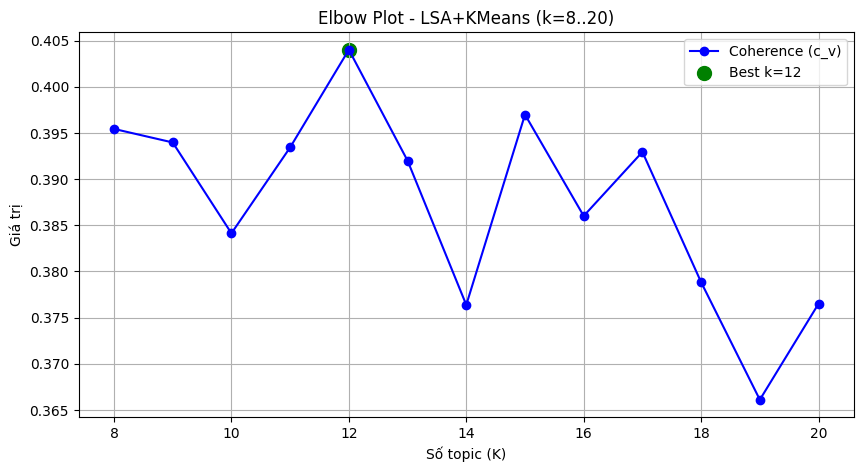

In [ ]:
# ============================================================
# KIỂM THỬ LSA VỚI NHIỀU SỐ CHỦ ĐỀ
# ============================================================
import pickle
import pandas as pd
import gensim
from gensim.models.coherencemodel import CoherenceModel
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# --- Load dữ liệu đã chuẩn bị ---
DF_PATH = "/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv"
TFIDF_PATH = "/content/drive/MyDrive/project2/project2c/tfidf_matrix.pkl"

df = pd.read_csv(DF_PATH)
texts = df["clean_text"].astype(str).tolist()

with open(TFIDF_PATH, "rb") as f:
    X_tfidf, vectorizer = pickle.load(f)

# --- Chuẩn bị cho coherence ---
tokens = [t.split() for t in texts]
dictionary = gensim.corpora.Dictionary(tokens)
feature_names = vectorizer.get_feature_names_out()

def lsa_top_words(model, feature_names, n_top_words=10):
    """Trả về top words cho từng topic từ LSA"""
    topics = []
    for comp in model.components_:
        idx = np.argsort(np.abs(comp))[-n_top_words:]
        idx = idx[np.argsort(-np.abs(comp[idx]))]
        top_words = [feature_names[i] for i in idx]
        topics.append(top_words)
    return topics

# --- Chạy thử với nhiều số chủ đề ---
k_list = list(range(8, 21))   # chỉ từ 8 → 20
results = []

for k in k_list:
    svd = TruncatedSVD(n_components=k, random_state=42)
    doc_topic = svd.fit_transform(X_tfidf)

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(doc_topic)

    topics_words = lsa_top_words(svd, feature_names, n_top_words=10)

    # coherence score
    cm = CoherenceModel(topics=topics_words, texts=tokens, dictionary=dictionary, coherence="c_v")
    coherence = cm.get_coherence()

    # explained variance
    variance = svd.explained_variance_ratio_.sum()

    results.append({"k": k, "coherence_c_v": coherence, "explained_variance": variance})
    print(f"LSA+KMeans | k={k:>2} → coherence={coherence:.4f} | explained_variance={variance:.4f}")

# --- Tổng hợp kết quả ---
res_df = pd.DataFrame(results).sort_values("k")
print("\n=== TỔNG HỢP KẾT QUẢ ===")
print(res_df)

SAVE_PATH = "/content/drive/MyDrive/project2/project2c/lsa_k8_20_results.csv"
res_df.to_csv(SAVE_PATH, index=False, encoding="utf-8-sig")
print(f"ĐÃ LƯU: {SAVE_PATH}")

# --- Vẽ elbow plot ---
plt.figure(figsize=(10,5))
plt.plot(res_df["k"], res_df["coherence_c_v"], marker="o", label="Coherence (c_v)", color="blue")
plt.xlabel("Số topic (K)")
plt.ylabel("Giá trị")
plt.title("Elbow Plot - LSA+KMeans (k=8..20)")
plt.legend()
plt.grid(True)

# highlight điểm tốt nhất theo coherence
best_idx = res_df["coherence_c_v"].idxmax()
best_k = res_df.loc[best_idx, "k"]
best_val = res_df.loc[best_idx, "coherence_c_v"]
plt.scatter(best_k, best_val, color="green", s=100, label=f"Best k={best_k}")
plt.legend()
plt.show()


 Sử dụng K = 12 cho LSA cuối cùng
ĐÃ LƯU MODEL: /content/drive/MyDrive/project2/project2c/lsa_final_k12.joblib
LSA - Topic 00: đại_học, tỉnh, học, tiền, triệu, hai, học_sinh, ảnh, chồng, trường, đồng, có_thể, việt_nam, đi, xe
LSA - Topic 01: sống, chẳng, đàn_ông, đi, bố_mẹ, dantri, yêu, trai, hôn_nhân, câu_chuyện, gái, xe, mẹ, vợ, chồng
LSA - Topic 02: sinh_viên, chồng, công_an, việt_nam, đồng, ô_tô, tài_xế, học, giáo_dục, mẫu, thi, đại_học, học_sinh, trường, xe
LSA - Topic 03: học_sinh, cầu_thủ, trận đấu, malaysia, hành_vi, xã, mẫu, giải, đội_tuyển, việt_nam, tỉnh, trận, đấu, công_an, xe
LSA - Topic 04: malaysia, đội_tuyển, đấu, giáo_dục, thi, công_an, trận, học, mẫu, đại_học, nga, ukraine, học_sinh, trường, xe
LSA - Topic 05: uav, fam, công_an, trận đấu, tổng_thống, giải, tên_lửa, fifa, cầu_thủ, malaysia, trận, đấu, đội_tuyển, nga, ukraine
LSA - Topic 06: thị_trường, lao_động, uav, tấn_công, công_ty, tên_lửa, việt_nam, tỷ đồng, tỷ, đồng, doanh_nghiệp, trường, học_sinh, nga, ukraine
L

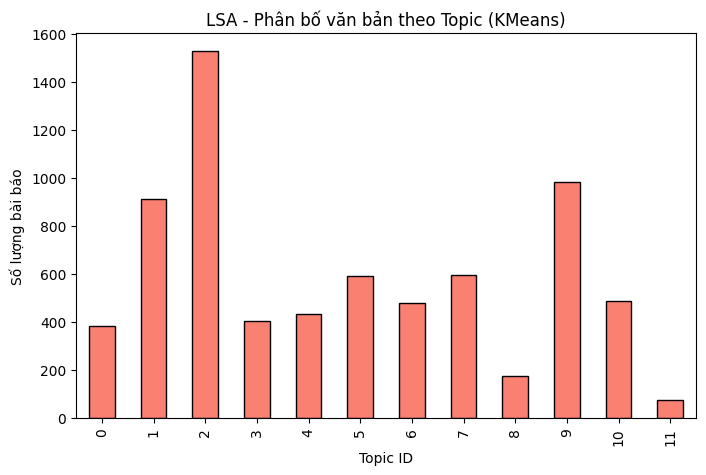

In [ ]:
# ============================================================
# HUẤN LUYỆN VÀ LƯU MÔ HÌNH LSA CUỐI CÙNG
# ============================================================
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import joblib
import numpy as np
import matplotlib.pyplot as plt

# --- Đặt k cố định ---
best_k = 12
print(f" Sử dụng K = {best_k} cho LSA cuối cùng")

# Huấn luyện mô hình LSA cuối cùng
final_lsa = TruncatedSVD(
    n_components=best_k,
    random_state=42
).fit(X_tfidf)

# Lưu model
save_path = f"/content/drive/MyDrive/project2/project2c/lsa_final_k{best_k}.joblib"
joblib.dump(final_lsa, save_path)
print(f"ĐÃ LƯU MODEL: {save_path}")

# --- In top từ cho từng topic ---
feature_names = vectorizer.get_feature_names_out()
topn = 15
topic_words = []
for idx, comp in enumerate(final_lsa.components_):
    top_idx = np.argsort(np.abs(comp))[-topn:]
    words = [feature_names[i] for i in top_idx]
    topic_words.append(", ".join(words))
    print(f"LSA - Topic {idx:02d}: {', '.join(words)}")

# --- Gán topic cho văn bản bằng KMeans ---
doc_topic = final_lsa.transform(X_tfidf)
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(doc_topic)

df["lsa_topic"] = labels
df["lsa_topwords"] = df["lsa_topic"].apply(lambda x: topic_words[x])

# Lưu lại gán nhãn
SAVE_PATH = "/content/drive/MyDrive/project2/project2c/lsa_topic_assignment.csv"
df.to_csv(SAVE_PATH, index=False, encoding="utf-8-sig")
print(f"ĐÃ LƯU: {SAVE_PATH}")

# --- Trực quan hóa phân bố topic ---
topic_counts = df["lsa_topic"].value_counts().sort_index()
plt.figure(figsize=(8,5))
topic_counts.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("LSA - Phân bố văn bản theo Topic (KMeans)")
plt.xlabel("Topic ID")
plt.ylabel("Số lượng bài báo")
plt.show()


LSA - Topic 00: đại_học, tỉnh, học, tiền, triệu, hai, học_sinh, ảnh, chồng, trường, đồng, có_thể, việt_nam, đi, xe
LSA - Topic 01: sống, chẳng, đàn_ông, đi, bố_mẹ, dantri, yêu, trai, hôn_nhân, câu_chuyện, gái, xe, mẹ, vợ, chồng
LSA - Topic 02: sinh_viên, chồng, công_an, việt_nam, đồng, ô_tô, tài_xế, học, giáo_dục, mẫu, thi, đại_học, học_sinh, trường, xe
LSA - Topic 03: học_sinh, cầu_thủ, trận đấu, malaysia, hành_vi, xã, mẫu, giải, đội_tuyển, việt_nam, tỉnh, trận, đấu, công_an, xe
LSA - Topic 04: malaysia, đội_tuyển, đấu, giáo_dục, thi, công_an, trận, học, mẫu, đại_học, nga, ukraine, học_sinh, trường, xe
LSA - Topic 05: uav, fam, công_an, trận đấu, tổng_thống, giải, tên_lửa, fifa, cầu_thủ, malaysia, trận, đấu, đội_tuyển, nga, ukraine
LSA - Topic 06: thị_trường, lao_động, uav, tấn_công, công_ty, tên_lửa, việt_nam, tỷ đồng, tỷ, đồng, doanh_nghiệp, trường, học_sinh, nga, ukraine
LSA - Topic 07: chồng, gan, y_tế, tỷ, người_bệnh, nga, đồng, ukraine, phẫu_thuật, bệnh_viện, bác_sĩ, bệnh, điều_

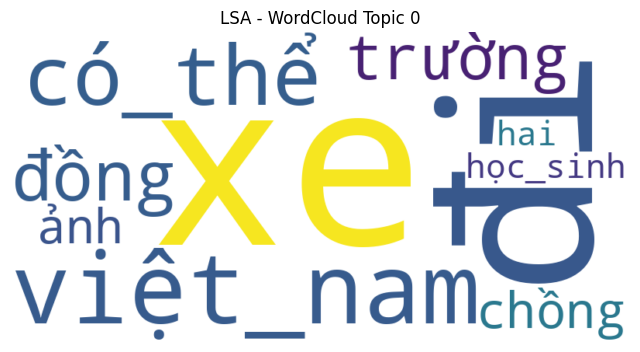

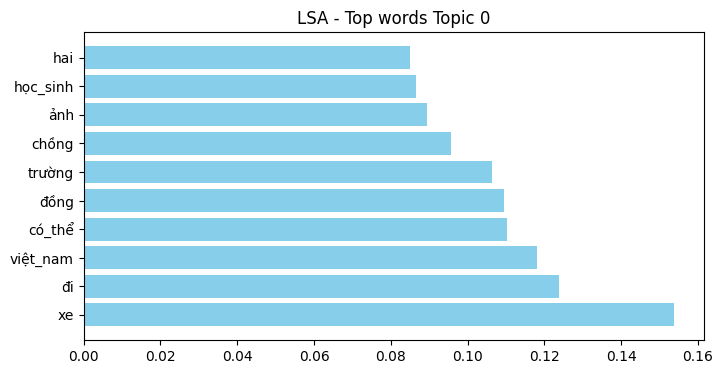

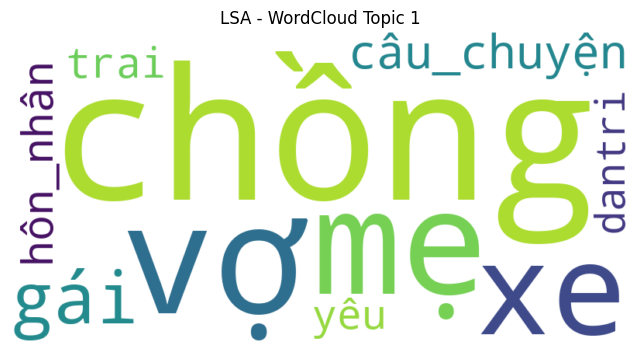

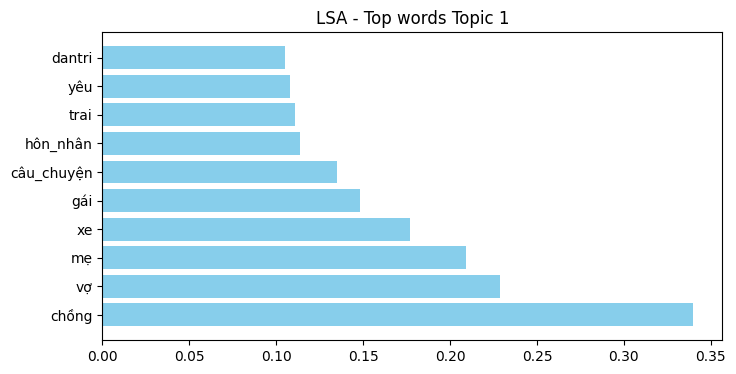

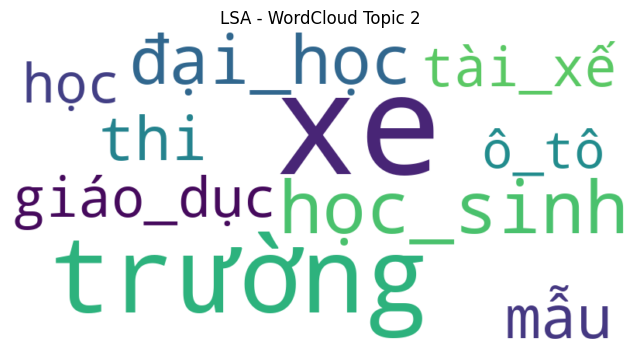

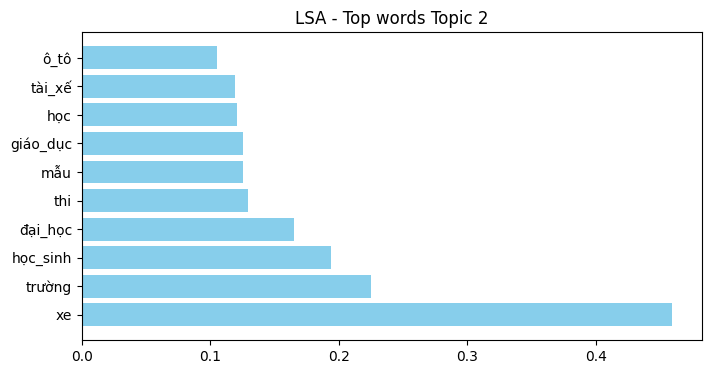

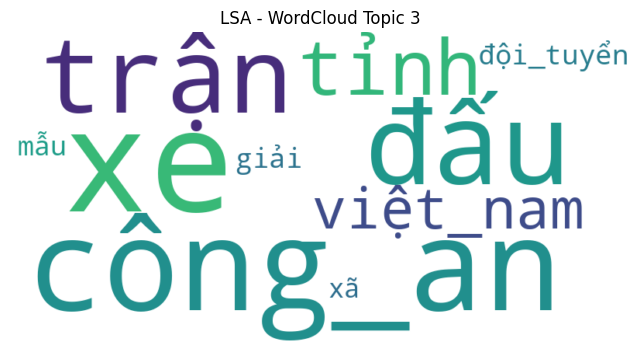

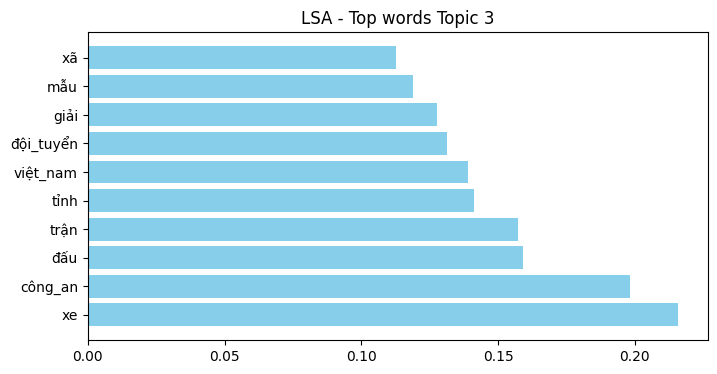

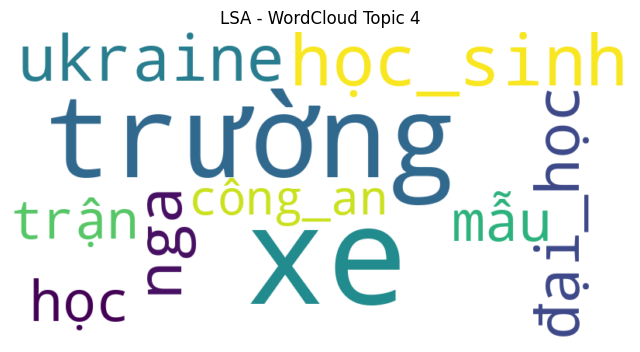

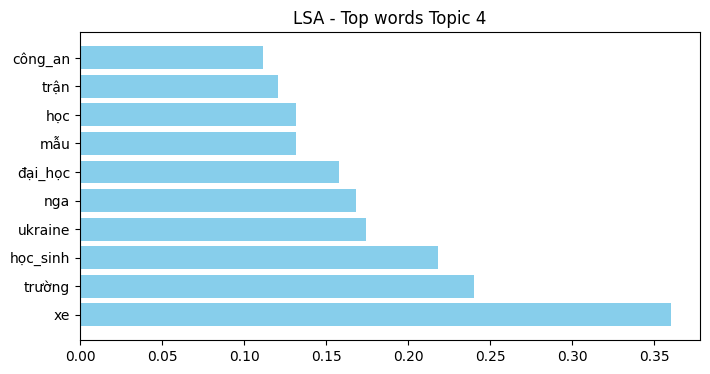

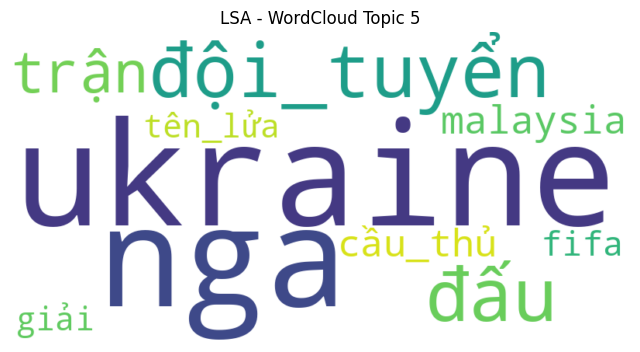

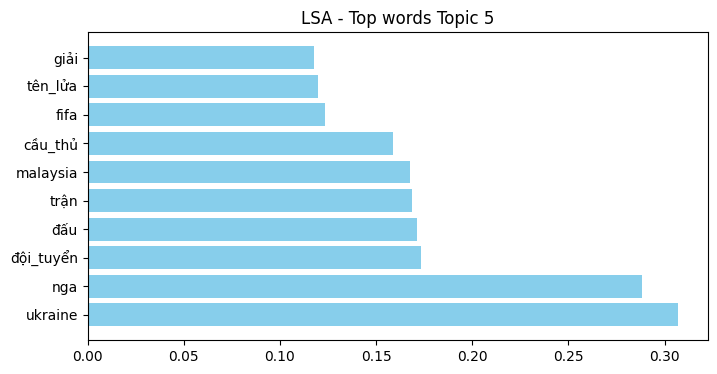

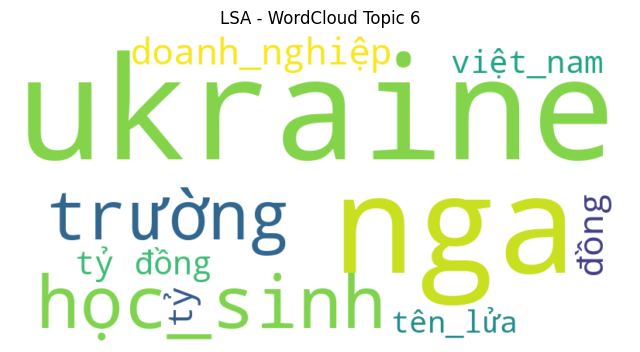

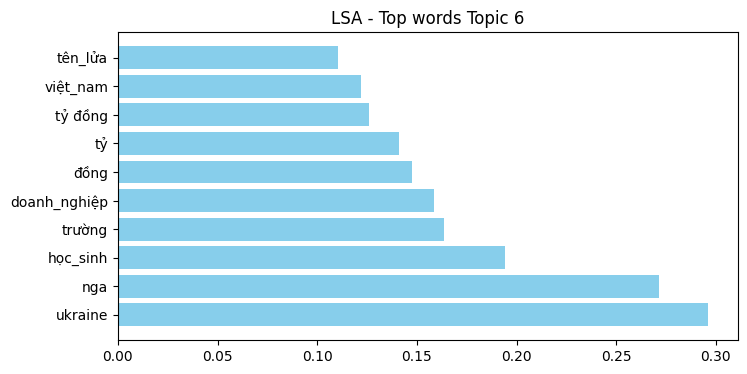

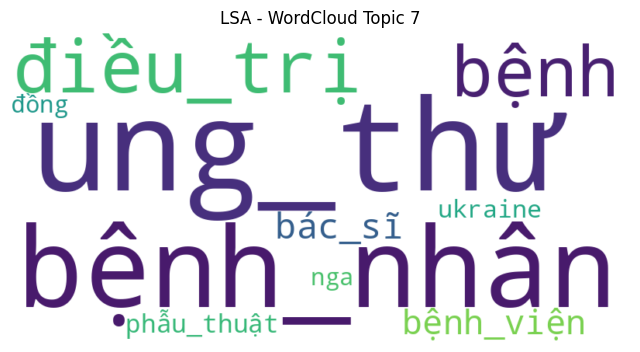

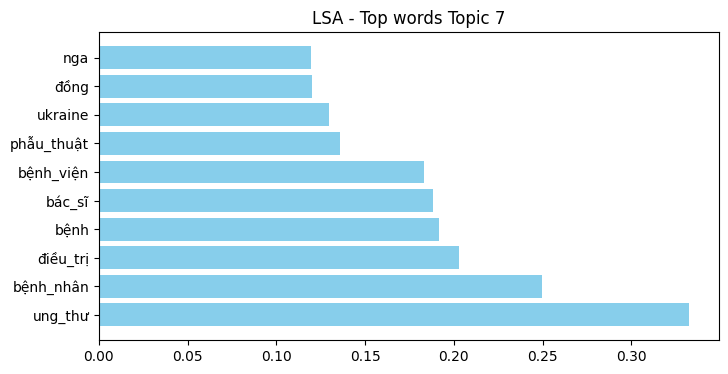

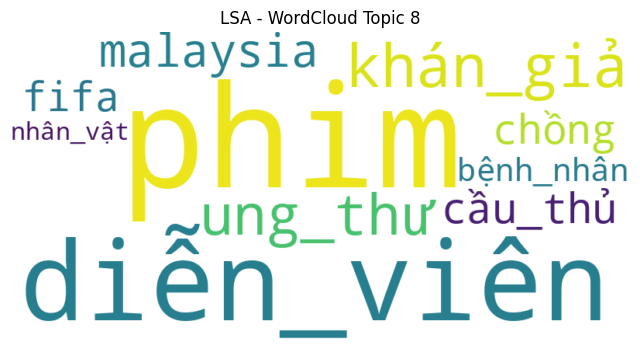

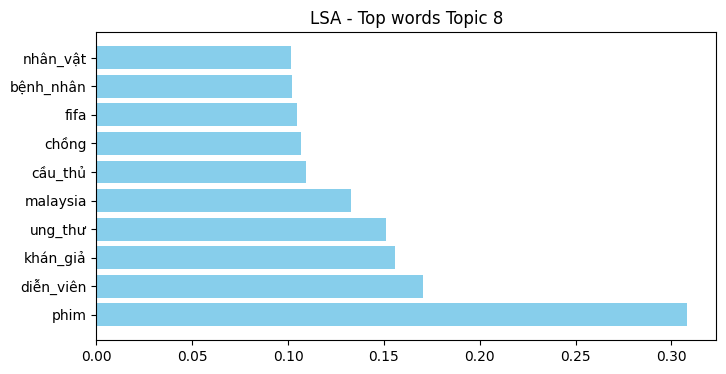

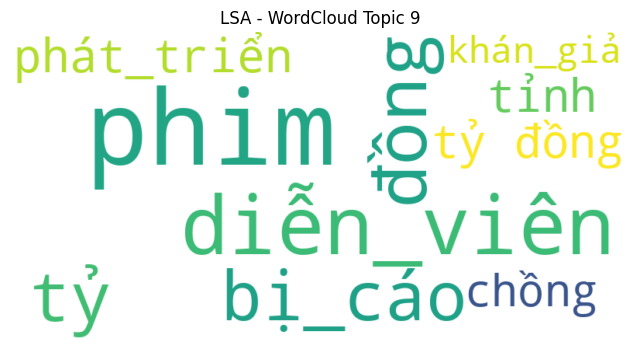

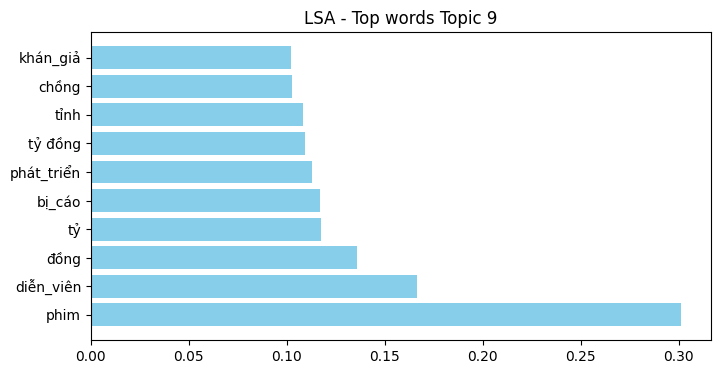

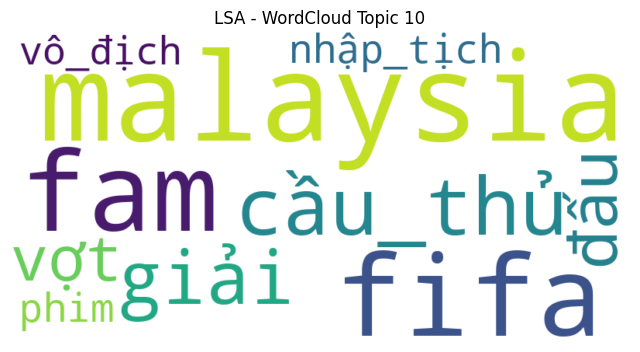

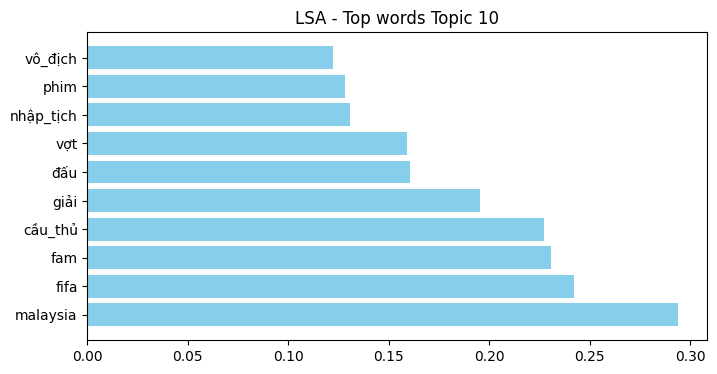

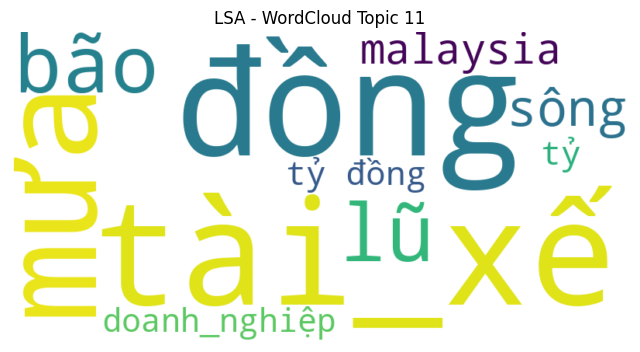

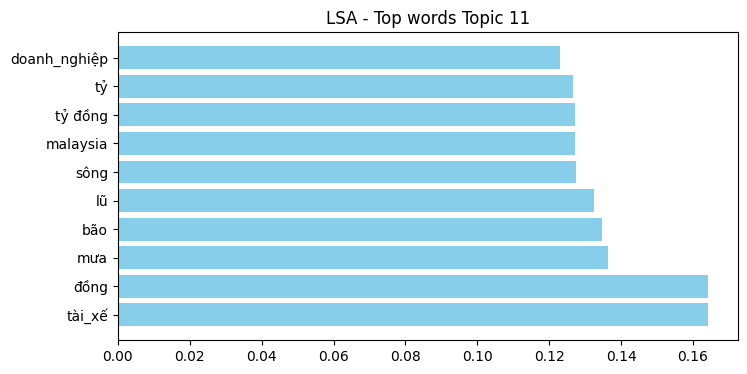

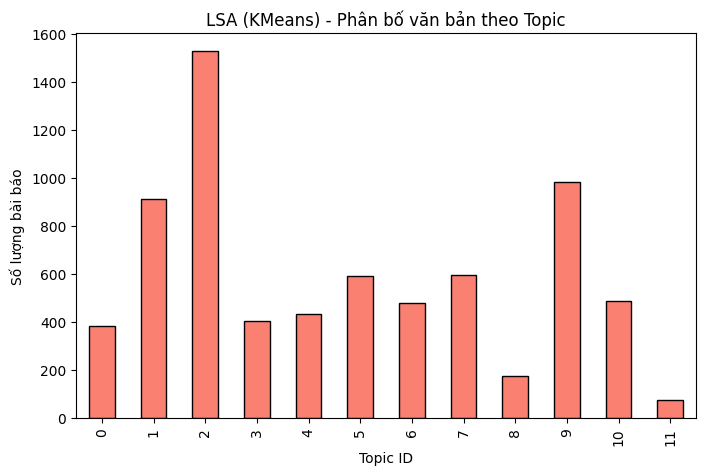

In [ ]:
# ============================================================
# PHÂN TÍCH TOPIC VỚI LSA (DÙNG KMeans)
# ============================================================
import pickle, pandas as pd, joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

# --- Load dữ liệu & TF-IDF ---
DF_PATH = "/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv"
TFIDF_PATH = "/content/drive/MyDrive/project2/project2c/tfidf_matrix.pkl"
MODEL_PATH = "/content/drive/MyDrive/project2/project2c/lsa_final_k12.joblib"   # đổi k theo best_k

df = pd.read_csv(DF_PATH)
texts = df["clean_text"].astype(str).tolist()

with open(TFIDF_PATH, "rb") as f:
    X_tfidf, vectorizer = pickle.load(f)

# --- Load mô hình LSA ---
lsa = joblib.load(MODEL_PATH)
feature_names = vectorizer.get_feature_names_out()

# --- Top words mỗi topic ---
topn = 15
topic_words = []
for idx, comp in enumerate(lsa.components_):
    top_idx = np.argsort(np.abs(comp))[-topn:]   # chọn theo |weight|
    words = [feature_names[i] for i in top_idx]
    topic_words.append(", ".join(words))
    print(f"LSA - Topic {idx:02d}: {', '.join(words)}")

# --- Gán topic cho văn bản bằng KMeans ---
doc_topic = lsa.transform(X_tfidf)
best_k = lsa.n_components
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(doc_topic)

df["topic_id"] = labels
df["topic_words"] = df["topic_id"].apply(lambda x: topic_words[x])

SAVE_PATH = "/content/drive/MyDrive/project2/project2c/lsa_topic_assignment.csv"
df.to_csv(SAVE_PATH, index=False, encoding="utf-8-sig")
print(f"ĐÃ LƯU: {SAVE_PATH}")

# --- Trực quan hóa ---
for idx, comp in enumerate(lsa.components_):
    top_idx = np.argsort(np.abs(comp))[-10:]
    words = [feature_names[i] for i in top_idx]
    weights = np.abs(comp[top_idx])

    # WordCloud
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(zip(words, weights)))
    plt.figure(figsize=(8,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"LSA - WordCloud Topic {idx}")
    plt.show()

    # Barplot
    plt.figure(figsize=(8,4))
    plt.barh(words[::-1], weights[::-1], color="skyblue")
    plt.title(f"LSA - Top words Topic {idx}")
    plt.show()

# --- Phân bố số văn bản theo topic ---
topic_counts = df["topic_id"].value_counts().sort_index()
plt.figure(figsize=(8,5))
topic_counts.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("LSA (KMeans) - Phân bố văn bản theo Topic")
plt.xlabel("Topic ID")
plt.ylabel("Số lượng bài báo")
plt.show()


### so sanh

In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# --- Load lại TF-IDF ---
with open(TFIDF_PATH, "rb") as f:
    X_tfidf, vectorizer = pickle.load(f)

# --- Load lại model LSA ---
lsa = joblib.load("/content/drive/MyDrive/project2/project2c/lsa_final_k12.joblib")
X_lsa = lsa.transform(X_tfidf)

# --- Chạy lại KMeans ---
best_k = 12
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X_lsa)

# --- Đọc nhãn ground-truth ---
df = pd.read_csv("/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv")
y_true = df["category"].astype("category").cat.codes

# --- Tính ARI & NMI ---
ari_lsa = adjusted_rand_score(y_true, y_pred)
nmi_lsa = normalized_mutual_info_score(y_true, y_pred)

print(f"LSA+KMeans (k={best_k}) → ARI = {ari_lsa:.4f}, NMI = {nmi_lsa:.4f}")


LSA+KMeans (k=12) → ARI = 0.3373, NMI = 0.5300


In [3]:
# ============================================================
# ĐÁNH GIÁ NMF VỚI ARI & NMI (KHÔNG DÙNG KMEANS)
# ============================================================
import pickle, joblib
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# --- Load dữ liệu & TF-IDF ---
DF_PATH = "/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv"
TFIDF_PATH = "/content/drive/MyDrive/project2/project2c/tfidf_matrix.pkl"
MODEL_PATH = "/content/drive/MyDrive/project2/project2c/nmf_final_k13.joblib"

df = pd.read_csv(DF_PATH)
y_true = df["category"].astype("category").cat.codes  # nhãn ground truth

with open(TFIDF_PATH, "rb") as f:
    X_tfidf, vectorizer = pickle.load(f)

# --- Load NMF model ---
nmf = joblib.load(MODEL_PATH)

# --- Lấy ma trận phân bổ chủ đề (document-topic distribution) ---
doc_topic = nmf.transform(X_tfidf)

# --- Gán mỗi văn bản vào topic có xác suất cao nhất ---
y_pred = doc_topic.argmax(axis=1)

# --- Tính ARI và NMI ---
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)

print(f"NMF (k=13) → ARI = {ari:.4f}, NMI = {nmi:.4f}")


NMF (k=13) → ARI = 0.4295, NMI = 0.5417


In [5]:
# ============================================================
# ĐÁNH GIÁ LDA VỚI ARI VÀ NMI
# ============================================================
import pandas as pd
import pickle, joblib
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# --- Đường dẫn ---
DF_PATH = "/content/drive/MyDrive/project2/project2c/dantri_qc_grouped.csv"
MODEL_PATH = "/content/drive/MyDrive/project2/project2c/lda_counts_final_k13.joblib"

# --- Load dữ liệu ---
df = pd.read_csv(DF_PATH)
texts = df["clean_text"].astype(str).tolist()
true_labels = df["category"].astype(str).tolist()   # ground truth category

# --- Load CountVectorizer để có X_counts ---
from sklearn.feature_extraction.text import CountVectorizer
counts_vectorizer = CountVectorizer(max_df=0.9, min_df=5)
X_counts = counts_vectorizer.fit_transform(texts)

# --- Load mô hình LDA đã lưu ---
lda = joblib.load(MODEL_PATH)

# --- Suy diễn phân bố chủ đề ---
doc_topic_dist = lda.transform(X_counts)   # shape: (n_docs, n_topics)
pred_labels = doc_topic_dist.argmax(axis=1)  # chọn topic có xác suất cao nhất

# --- Tính ARI và NMI ---
ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)

print(f"LDA (final) → ARI = {ari:.4f}, NMI = {nmi:.4f}")


LDA (final) → ARI = 0.3989, NMI = 0.5234


=== Kết quả so sánh mô hình ===
  Model  Coherence     ARI     NMI
0   LDA     0.6642  0.3989  0.5234
1   NMF     0.8405  0.4295  0.5417
2   LSA     0.4040  0.3373  0.5300


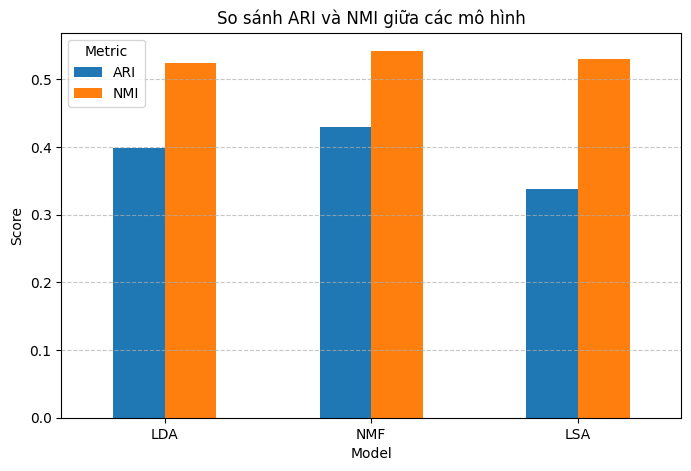

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# Nhập kết quả có sẵn
# ============================================================
results = pd.DataFrame({
    "Model": ["LDA", "NMF", "LSA"],
    "Coherence": [0.6642, 0.8405, 0.4040],
    "ARI": [0.3989, 0.4295, 0.3373],
    "NMI": [0.5234, 0.5417,  0.5300]
})

print("=== Kết quả so sánh mô hình ===")
print(results)

# ============================================================
# Vẽ biểu đồ cột ARI & NMI
# ============================================================
results.set_index("Model")[["ARI", "NMI"]].plot(kind="bar", figsize=(8,5))
plt.title("So sánh ARI và NMI giữa các mô hình")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
